# 1. Objective dan Deskripsi Kolom

Objective       :

Program ini dibuat untuk membuat model machine learning yang dapat mengklasifikasi dan memprediksi status gagal atau tidaknya pembayaran asuransi seseorang pada bulan depan



Gambaran Dataset :

Data yang digunakan adalah data nasabah pemegang kartu kredit dari Taiwan.

### 1.1. Deskripsi kolom

Berikut adalah deskripsi dari setiap kolom :

1. limit_balance              : Jumlah kredit yang diberikan ($) termasuk kredit individu dan keluarga/tambahan
2. sex                        : Gender
4. education_level            : Level edukasi terakhir dengan kategori graduate school (1), university (2), high school (3), others (4), unknown (5), unknown (6)
5. martial_status             : Marital status dengan kategori married (1), single (2), others (3)
6. age                        : Umur
7. pay                        : Kolom pay menjelaskan mengenai status pelunasan kredit yang diambil dari bulan April 2005 hingga bulan September 2005. Nilai -2 = tidak ada konsumsi, -1 = tepat waktu, 0 = payment minimum terpenuhi, 1 = terlambat 1 bulan, 2 = terlambat 2 bulan,..dst
   - pay_0                    : Status pelunasan pada bulan September  
   - pay_2                    : Status pelunasan pada bulan Agustus  
   - pay_3                    : Status pelunasan pada bulan Juli  
   - pay_4                    : Status pelunasan pada bulan Juni 
   - pay_5                    : Status pelunasan pada bulan Mei
   - pay_6                    : Status pelunasan pada bulan April 
8. bill_amt                   : Kolom bill_amt berisi nilai - nilai yang menggambarkan jumlah tagihan kartu kredit yang diambil dari bulan April 2005 hingga bulan September 2005
   - bill_amt1                : Jumlah tagihan pada bulan September 2005 (NT dollar)
   - bill_amt2                : Jumlah tagihan pada bulan Agustus 2005 (NT dollar)
   - bill_amt3                : Jumlah tagihan pada bulan July 2005 (NT dollar)
   - bill_amt4                : Jumlah tagihan pada bulan Juni 2005 (NT dollar)
   - bill_amt5                : Jumlah tagihan pada bulan Mei 2005 (NT dollar)
   - bill_amt6                : Jumlah tagihan pada bulan April 2005 (NT dollar)
9. pay_amt                    : Kolom pay_amt berisi nilai - nilai yang menggambarkan jumlah pembayarah sebelumnya 
   - pay_amt1                 : Jumlah pembayaran sebelumnya pada bulan September
   - pay_amt2                 : Jumlah pembayaran sebelumnya pada bulan Agustus
   - pay_amt3                 : Jumlah pembayaran sebelumnya pada bulan Juli
   - pay_amt4                 : Jumlah pembayaran sebelumnya pada bulan Juni
   - pay_amt5                 : Jumlah pembayaran sebelumnya pada bulan Mei
   - pay_amt6                 : Jumlah pembayaran sebelumnya pada bulan April
10. default_payment_next_month: Gagal bayar (1 = yes, 0 = no)



# 2. Query SQL 

Query dibawah ini dibuat untuk mengambil dataset dari bigquery menggunakan google colab

from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "fine-advantage-424306-i2" 
client = bigquery.Client(project=project_id)

df = client.query('''
SELECT
  limit_balance, cast(sex as integer) as sex,cast(education_level as integer) as education_level, cast(marital_status as integer) as martial_status, age, pay_0, pay_2, pay_3, pay_4, 
  cast(pay_5 as float64) as pay_5, cast(pay_6 as float64) as pay_6, bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, 
  bill_amt_5, bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6,
  cast(default_payment_next_month as integer) as default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 33949
''').to_dataframe()

# 3. Import libraries

In [2]:
# Import tools dasar
import pandas as pd
import numpy as np
from scipy import stats

# Library Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Library outliers handling
from feature_engine.outliers import Winsorizer

# Library scaling 
from sklearn.preprocessing import RobustScaler

# Model linear regresion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Library Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Save Model
import pickle
import joblib
import json

# Library matriks regresi linear
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Libbrary untuk cross validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Library untuk tuning hyperparameter
from sklearn.model_selection import GridSearchCV


# 4. Data loading

Data diambil dari google cloud dengan alamat web sebagai berikut : 

https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=fine-advantage-424306-i2

In [3]:
# Membuat dataframe utama
df = pd.read_csv('creditCard.csv')
pd.set_option('display.max_columns', None)

# Cek dataframe
df.head()

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


In [4]:
# Menampilkan 10 dataset pertama
df.head(10)

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,-1.0,54053.0,65235.0,64747.0,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,0.0,58180.0,59134.0,61156.0,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,192461.0,195970.0,122214.0,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,0.0,133598.0,167378.0,171106.0,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,0.0,160879.0,161797.0,165107.0,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [5]:
# Menampilkan 10 dataset terakhir
df.tail(10)

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,1968.0,459.0,2500.0,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,-2.0,12878.0,7702.0,2377.0,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,-2.0,-100.0,100.0,0.0,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,5280.0,5000.0,5000.0,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,96.0,780.0,0.0,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,-2.0,4280.0,2800.0,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,-2.0,752.0,300.0,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,390.0,390.0,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1473.0,390.0,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-70.0,9540.0,390.0,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


In [6]:
# Menampilkan info basic dari dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   martial_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

In [7]:
# Cek unique values dari kolom pay_0
df['pay_0'].value_counts()

pay_0
 0.0    1516
-1.0     540
 1.0     356
 2.0     262
-2.0     247
 3.0      29
 4.0       7
 8.0       3
 5.0       2
 7.0       2
 6.0       1
Name: count, dtype: int64

In [8]:
# Cek basic info dataframe dari seluruh columns
columns = []
dtype = []
notnull = []

for col in df.columns :
    columns.append(col)
    dtype.append(df[col].dtype)
    notnull.append(df[col].isna().sum())

fd = {'column': columns, 'dtype' : dtype, 'notnull' : notnull}
fd = pd.DataFrame(fd)
fd

,column,dtype,notnull
0,limit_balance,float64,0
1,sex,int64,0
2,education_level,int64,0
3,martial_status,int64,0
4,age,float64,0
5,pay_0,float64,0
6,pay_2,float64,0
7,pay_3,float64,0
8,pay_4,float64,0
9,pay_5,float64,0


Insight :

1. Seluruh tipe data dari masing - masing kolom sudah sesuai

2. Dari basic info di atas tidak ditemukan standard non missing di seluruh kolom

3. Total ada 2965 lines dan 24 kolom. Pada dataset ini kolom - kolom tersebut dapat dikategorikan lagi menjadi :
   - Data demografik    : age, education_levels, martial_status, sex
   - Payment history    : pay_n, bill_amt_n, dan pay_amt_n
   - Status individu    : default_payment_next_month

4. Pada kolom pay_n (n = bulan), nilai -2 dan -1 dapat diubah menjadi nilai 0 karena kedua nilai tersebut menggambarkan kondisi yang sama yaitu tidak ada keterlambatan pembayaran

5. Terdapat 2965 baris dan 23 kolom dimana 4 kolom diantaranya (martial_status, education_level, sex, dan default_payment_next_month) merupakan kolom bertipe kategorik yang nilainya sudah diencoding

6. Tidak ada kolom yang nilainya memiliki hubungan matematis dengan nilai pada kolom lain pada satu baris yang sama, hal ini sangat mempersulit analisa bisnis

Note :
Agar memudahkan interpretasi, kolom - kolom seperti pay_n, bill_amt_n, dan pay_amt_n (nilai n mewakili angka 1 sampai 6) akan diubah menjadi nama 3 huruf depan bulan



### 4.1. Cek Missing values

In [9]:
# Cek missing values
df.isna().sum()

limit_balance                 0
sex                           0
education_level               0
martial_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Dari hasil pengecekan di atas, tidak ditemukan adanya missing values pada seluruh kolom

### 4.2. Cek baris duplikat

In [10]:
# Cek baris duplikat
df.duplicated().sum()

1

In [11]:
# Cek baris dengan nilai duplikat
df[df.duplicated()]

,limit_balance,sex,education_level,martial_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2815,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Dari 2965 baris, hanya ada 1 baris duplikat. Bari duplikat tersebut akan langsung kita hapus

In [12]:
# Hapus baris duplikat
df.drop_duplicates(inplace=True,ignore_index=True)

# Cek hasil
df.duplicated().sum()

0

### 4.3. Mengubah nama kolom

Bagian ini ditujukan untuk mengubah nama kolom dataframe agar lebih mudah untuk diinterpretasikan.

In [13]:
# Mengganti nama kolom
df.rename(columns={'pay_0' : 'pay_sept', 'pay_2' : 'pay_aug', 'pay_3' : 'pay_jul', 'pay_4' : 'pay_jun', 'pay_5' : 'pay_may', 'pay_6' : 'pay_apr', 'bill_amt_1' : 'bill_amt_sept', 'bill_amt_2' : 'bill_amt_aug',
                   'bill_amt_3' : 'bill_amt_jul', 'bill_amt_4' : 'bill_amt_jun', 'bill_amt_5' : 'bill_amt_may', 'bill_amt_6' : 'bill_amt_apr', 'pay_amt_1' : 'pay_amt_sept', 'pay_amt_2' : 'pay_amt_aug',
                    'pay_amt_3' : 'pay_amt_jul', 'pay_amt_4' : 'pay_amt_jun', 'pay_amt_5' : 'pay_amt_may', 'pay_amt_6' : 'pay_amt_apr'}, inplace=True)

# Cek hasil
df.head(1)

,limit_balance,sex,education_level,martial_status,age,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,bill_amt_sept,bill_amt_aug,bill_amt_jul,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1


### 4.5. Mengubah values kolom education_level

Terdapat 6 jenis unique values pada bagian education_level yaitu 1 = graduate school, 2 = university/undergraduate, 3 = high school, 4 = others, 5 = unknown, 6 = unknown. Dari penjelasan tersebut dapat terlihat jika unknown memiliki 2 nilai yaitu 5 dan 6. Oleh karena itu, seluruh nilai 6 pada kolom education_level akan diganti menjadi 5

In [14]:
# Cek jumlah nilai 6 dan 5 pada kolom education_level
print(f'Total row nilai 5 = {len(df.loc[df["education_level"] == 5])}')
print(f'Total row nilai 6 = {len(df.loc[df["education_level"] == 6])}')

Total row nilai 5 = 24
Total row nilai 6 = 4


In [15]:
# Mengganti nilai 6 dengan 5 pada kolom education_level
df['education_level'] = df['education_level'].replace(6,5)

In [16]:
# Cek hasil
print(f'Total row nilai 5 = {len(df.loc[df["education_level"] == 5])}')
print(f'Total row nilai 6 = {len(df.loc[df["education_level"] == 6])}')

Total row nilai 5 = 28
Total row nilai 6 = 0


### 4.6. Mengubah nilai pada kolom pay_n

Seperti yang sudah dijelaskan pada bagian awal, terdapat nilai -2, -1, dan 0 pada kolom pay_n yang pada dasarnya ketiga nilai tersebut menjelaskan bahwa customer tersebut tidak terlambat dalam membayar tagihan kartu kredit. Nilai -1 dan -2 akan kita ubah menjad nilai 0 untuk memudahkan interpretasi sehingga hanya ada 2 kemungkinan pada kolom tersebut, telat membayar dan tidak telat membayar. 

Sumber pertimbangan :

1. https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/71771#423791

2. https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [17]:
for columns in df.iloc[:,5:11] :
    df[columns] = df[col].replace([-2,-1],0)

print(f'Total row dengan nilai -2 pada kolom pay_sept = {len(df.loc[df["pay_sept"] == -2])}')
print(f'Total row dengan nilai -1 pada kolom pay_sept = {len(df.loc[df["pay_sept"] == -1])}')

Total row dengan nilai -2 pada kolom pay_sept = 0
Total row dengan nilai -1 pada kolom pay_sept = 0


### 4.7. Mengubah tipe data kolom pay_n

In [18]:
# Mengganti tipe data Jumlah Terjual dan Harga
for col in df.iloc[:,5:11] :
    df[col] = df[col].astype('int64')

In [19]:
# Cek hasil
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964 entries, 0 to 2963
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   martial_status              2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_sept                    2964 non-null   int64  
 6   pay_aug                     2964 non-null   int64  
 7   pay_jul                     2964 non-null   int64  
 8   pay_jun                     2964 non-null   int64  
 9   pay_may                     2964 non-null   int64  
 10  pay_apr                     2964 non-null   int64  
 11  bill_amt_sept               2964 non-null   float64
 12  bill_amt_aug                2964 non-null   float64
 13  bill_amt_jul                2964 

# 4. EDA

### 4.1. Basic info statistik dataframe

In [20]:
# Cek basic info data numerik
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
limit_balance,2964.0,163356.950067,125049.701016,10000.0,50000.00,140000.0,230000.00,800000.0
sex,2964.0,1.607625,0.488362,1.0,1.00,2.0,2.00,2.0
education_level,2964.0,1.848516,0.771800,0.0,1.00,2.0,2.00,5.0
martial_status,2964.0,1.560054,0.522304,0.0,1.00,2.0,2.00,3.0
age,2964.0,35.193657,9.110949,21.0,28.00,34.0,41.00,69.0
pay_sept,2964.0,0.214238,0.410362,0.0,0.00,0.0,0.00,1.0
pay_aug,2964.0,0.214238,0.410362,0.0,0.00,0.0,0.00,1.0
pay_jul,2964.0,0.214238,0.410362,0.0,0.00,0.0,0.00,1.0
pay_jun,2964.0,0.214238,0.410362,0.0,0.00,0.0,0.00,1.0
pay_may,2964.0,0.214238,0.410362,0.0,0.00,0.0,0.00,1.0


Insight :
1. Rata - rata limit kartu kredit yang diberikan oleh kreditur sebesar 163356.95 NT, dengan nilai minimal 10000 NT dan nilai maksimal 80000 NT. Kemungkinan data pada kolom ini memiliki variasi yang sangat banyak karena nilai standar deviasinya (sebesar 125049.701) jauh dari nilai mean (163356.950)

2. Rata - rata pemegang kartu kredit berada pada usia 35 tahun, dengan usia termuda 21 tahun dan usia tertua 69 tahun. Hal ini mengindikasikan bahwa kreditur masih memberikan pinjaman kartu kredit pada individu - individu yang memiliki usia di atas usia pensiun


### 4.2. Analisis univariat

#### 4.2.1. Melihat proporsi masing - masing nilai pada kolom target

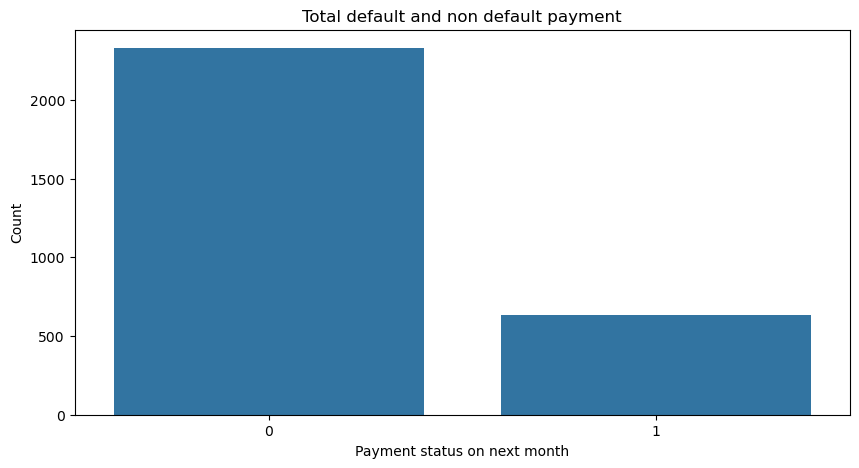

In [21]:
# Grafik total default dan non default payment
plt.figure(figsize = (10,5))
sns.countplot(data=df, x='default_payment_next_month')
plt.title('Total default and non default payment')
plt.xlabel('Payment status on next month')
plt.ylabel('Count')
plt.show()


In [22]:
# Melihat presentase default dan non default payment
print(f'% Default payment = {round((len(df.loc[df["default_payment_next_month"]==1])/len(df["default_payment_next_month"]))*100,2)} %')
print(f'% Non default payment = {round((len(df.loc[df["default_payment_next_month"]==0])/len(df["default_payment_next_month"]))*100,2)} %')

% Default payment = 21.42 %
% Non default payment = 78.58 %


Dari nilai di atas kita dapat melihat jika presentase pemegang kartu kredit yang memiliki status potensi gagal bayar pada bulan depan sebesar 21.42 %, sementara itu 75.58 % nya adalah pemegang kartu kredit yang memiliki potensi dapat membayar tagihan pada bulan depan. Ketidakimbangan tersebut dapat membuat masalah pada proses pembelajaran model karena model lebih banyak mempelajari individu yang berpotensi dapat membayar tagihan dibandingkan individu yang berpotensi tidak dapat membayar tagihan. Hal ini dapat menyebabkan prediksi model menjadi bias

#### 4.2.2. Jumlah pemilik kartu kredit berdasarkan gender

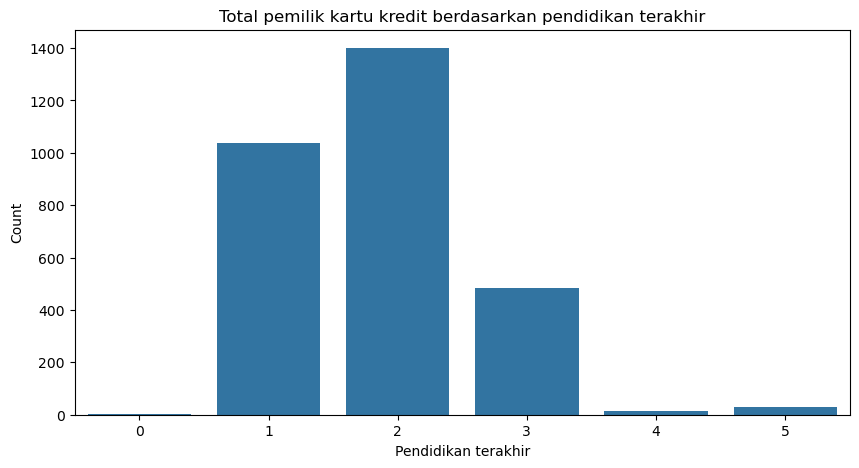

In [23]:
# Grafik jumlah pemegang kartu kredit berdasarkan pendidikan terakhir
plt.figure(figsize = (10,5))
sns.countplot(data=df, x='education_level')
plt.title('Total pemilik kartu kredit berdasarkan pendidikan terakhir')
plt.xlabel('Pendidikan terakhir')
plt.ylabel('Count')
plt.show()

Dari grafik diatas dapat terlihat jika sebagian besar pemegang kartu kredit berasal dari kalangan dengan pendidikan terakhir di atas bachelor degree (2), diikuti oleh kalangan dengan pendidikan terakhir bachelor degree (1), dan sekolah menengah atas (3). Hal ini mengindikasikan adanya hubungan antara tingkat pendidikan dengan pengetahuan atau keinginan pada produk keuangan seperti kartu kredit

#### 4.2.3. Jumlah pemilik kartu kredit berdasarkan umur

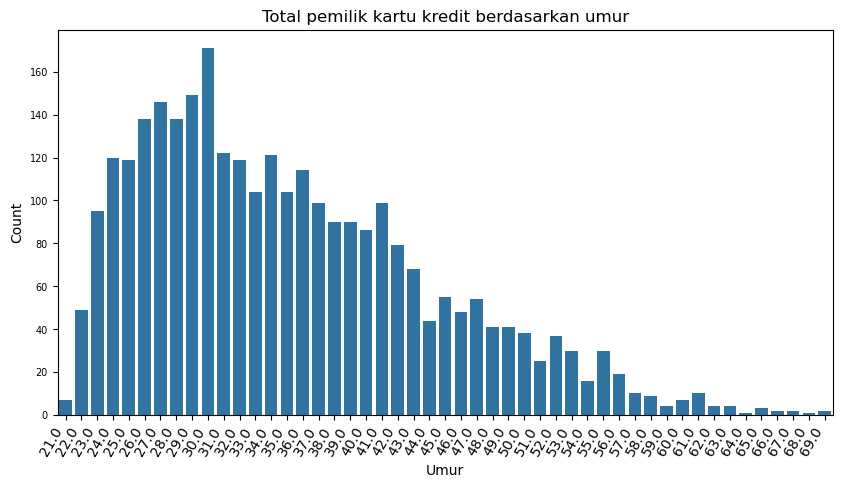

In [24]:
# Grafik jumlah pemegang kartu kredit berdasarkan pendidikan terakhir
plt.figure(figsize = (10,5))
sns.countplot(data=df, x='age')
plt.title('Total pemilik kartu kredit berdasarkan umur')
plt.xlabel('Umur')
plt.ylabel('Count')
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.yticks(fontsize=7)
plt.show()

Dari gambar di atas dapat terlihat jika distribusi jumlah pemegang kartu kredit akan berkurang pada usia lebih dari 31 tahun. Hal ini mengindikasikan adanya kekurangan minat masyarakt untuk menggunakan kartu kredit ketika umurnya semakin tua

### 4.3. Analisis bivariat

#### 4.3.1. Hubungan antara tingkat pendidikan terakhir dengan status gagal bayar

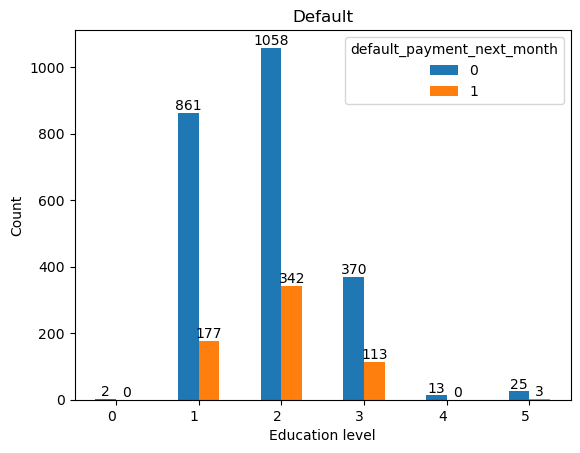

In [25]:
# Menampilkan grafik hubungan antara tingkat pendidikan dengan status gagal bayar
default_by_education = df.groupby(['education_level', 'default_payment_next_month']).size().unstack()

ax = default_by_education.plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel('Education level')
ax.set_ylabel('Count')
ax.set_title('Default')
plt.xticks(rotation=0, ha='right', fontsize=10)

plt.show()

Dari data di atas dapat dilihat jika status gagal bayar tertinggi berasal dari kelompok dengan tingkat pendidikan akhir graduate degree (2), diikuti dengan tingat pendidikan bachelor degree (1), high school (3), dan others (4 dan 5). Selain itu, dari data di atas juga dapat dilihat jika kelompok dengan tingkat pendidikan akhir graduate degree memiliki jumlah status tidak gagal bayar tertinggi, diikuti dengan tingkat pendidikan bachelor degree, high school, dan others. Hal ini mengindikasikan jika tidak terdapat hubungan yang linier antara status pendidikan akhir dengan kemungkinan customer tersebut akan memiliki status gagal bayar atau tidak gagal bayar. Jika dihubungkan dengan grafik jumlah pemegang kartu kredit berdasarkan pendidikan terakhir, status gagal bayar dan tidak gagal bayar lebih memiliki relevansi terhadap kelompok yang memiliki jumlah pemegang kartu kredit terbanyak

#### 4.3.2. Hubungan antara umur dan limit balance

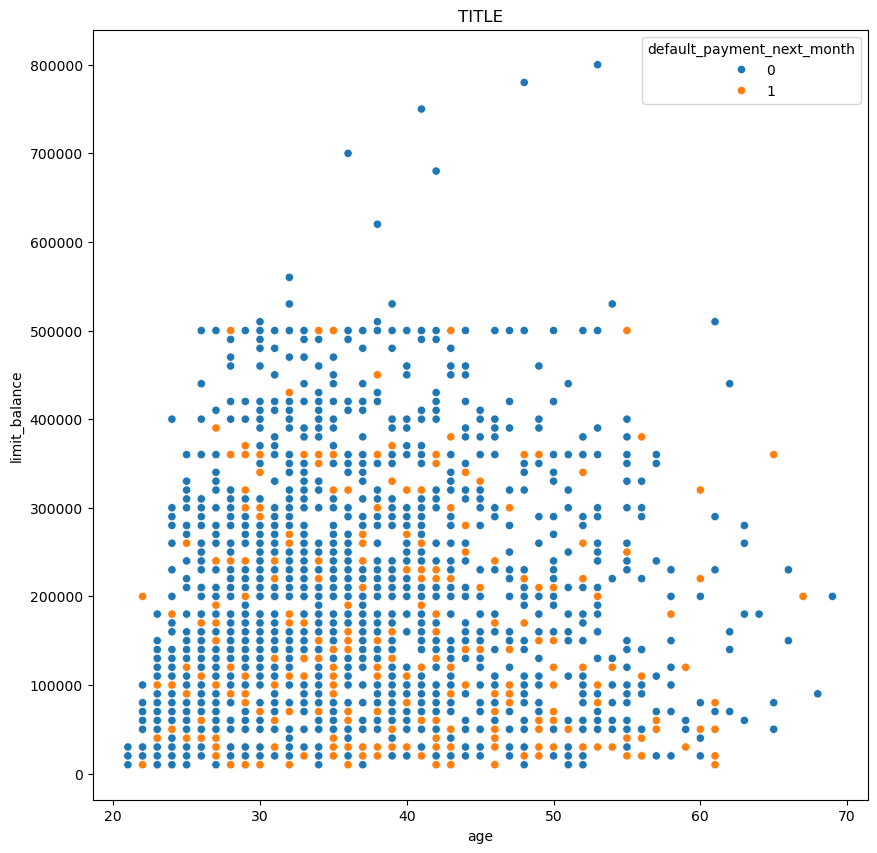

In [26]:
# Menampilkan grafik hubungan antara limit balance dengan age
plt.figure(figsize = (10,10))
sns.scatterplot(x='age', y='limit_balance', data=df, hue='default_payment_next_month')
plt.title('TITLE')
plt.show()

Dari grafik di atas dapat diambil 2 keseimpulan, yaitu :
1. Terdapat indikasi besar bahwa tidak ada hubungan linier antara limit balance dengan umur pemegang kartu kredit karena plot - plot tersebut tidak memiliki pola linier. Artinya besarnya pemberian limit balance bergantung dengan variable lain. Jika dilihat dari business knowledge, kemungkinan variable tersebut adalah jumlah tabungan dan history pembayaran sebelumnya karena kedua variable dapat meningkatkan rasa aman dan kepercayaan dari kreditur
2. Tidak ada hubungan linier antara status gagal bayar dengan umur pemegang kartu kredit, hal ini dikarenakan plot yang menggambarkan status gagal bayar (warna oranye) terdistribusi secara acak dan tidak mengikuti pola linier




<Figure size 1500x500 with 0 Axes>

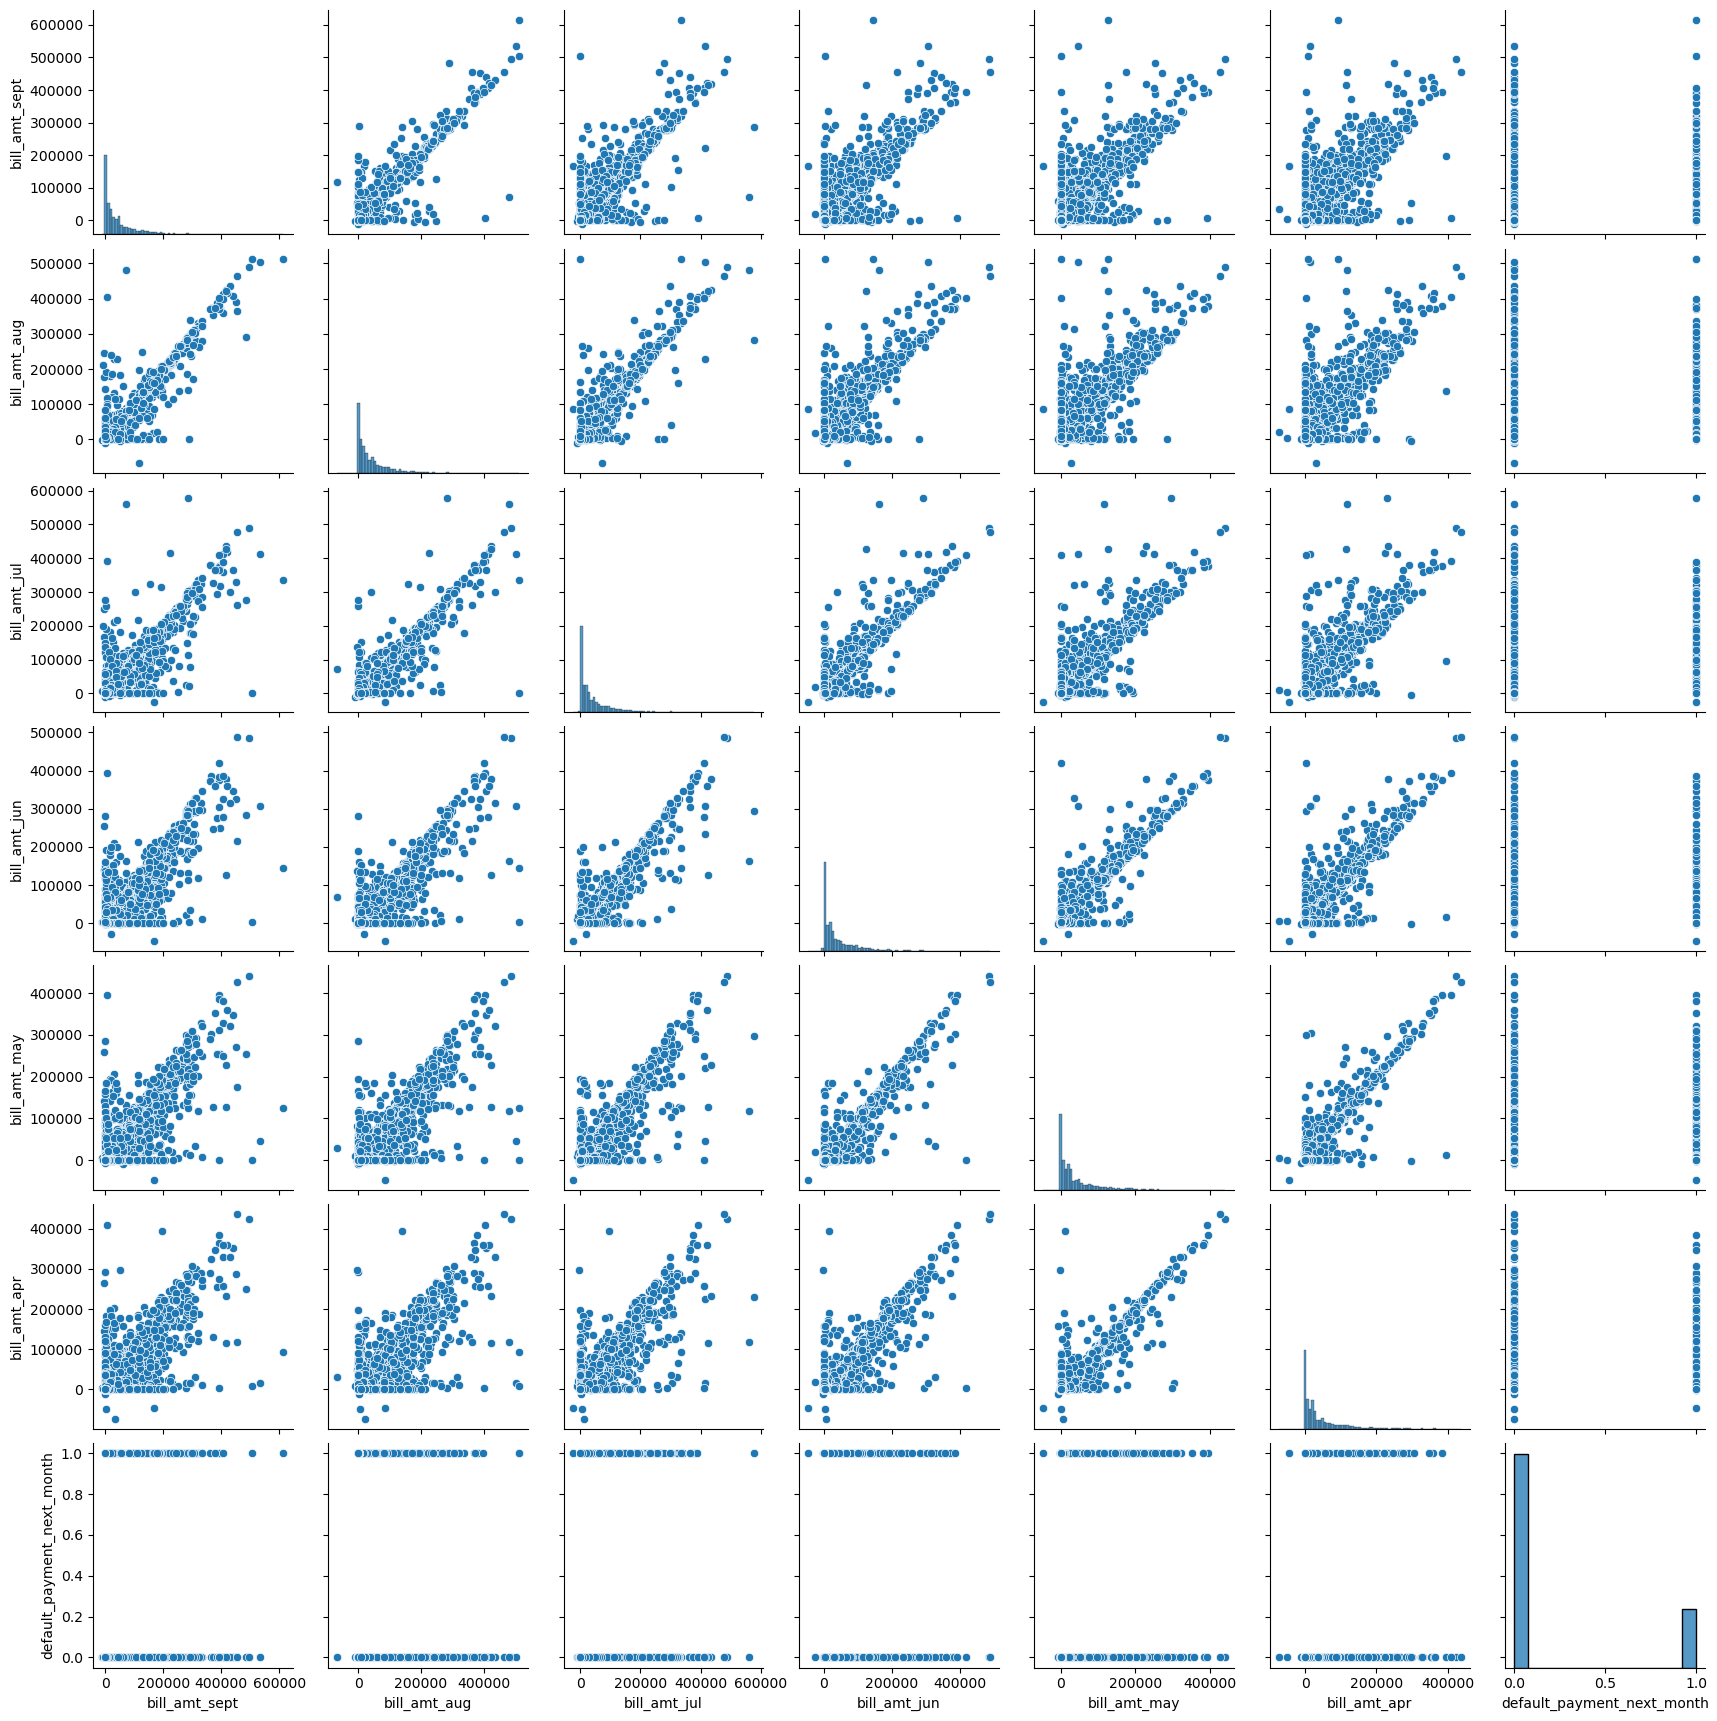

In [27]:
# Membuat pairplot 
plt.figure(figsize=(15,5))
sns.pairplot(df[['bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'default_payment_next_month']])
plt.show()

# 5. Feature engineering

### 5.1. Split train test

Proses ini akan membagi dataset menjadi 2 jenis yaitu dataset training dan dataset test. Masing - masing kategori tersebut akan dibagi lagi menjadi 2 jenis yaitu dataset x (sebagai independetn variable) dan dataset y (sebagai dependent variable). Dataset training akan memperoleh 80% dari total baris sementara dataset test akan memperoleh 20% dari total baris.

In [28]:
# Menentukan features dan variable target
x = df.drop('default_payment_next_month',axis=1)
y = df['default_payment_next_month']

# Membuat data training dan test menggunakan fungsi train_test_split()
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=50)

In [29]:
# Cek hasil xtrain
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2371 entries, 21 to 1712
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   limit_balance    2371 non-null   float64
 1   sex              2371 non-null   int64  
 2   education_level  2371 non-null   int64  
 3   martial_status   2371 non-null   int64  
 4   age              2371 non-null   float64
 5   pay_sept         2371 non-null   int64  
 6   pay_aug          2371 non-null   int64  
 7   pay_jul          2371 non-null   int64  
 8   pay_jun          2371 non-null   int64  
 9   pay_may          2371 non-null   int64  
 10  pay_apr          2371 non-null   int64  
 11  bill_amt_sept    2371 non-null   float64
 12  bill_amt_aug     2371 non-null   float64
 13  bill_amt_jul     2371 non-null   float64
 14  bill_amt_jun     2371 non-null   float64
 15  bill_amt_may     2371 non-null   float64
 16  bill_amt_apr     2371 non-null   float64
 17  pay_amt_sept     2

In [30]:
# Cek hasil ytrain
ytrain.info()

<class 'pandas.core.series.Series'>
Index: 2371 entries, 21 to 1712
Series name: default_payment_next_month
Non-Null Count  Dtype
--------------  -----
2371 non-null   int64
dtypes: int64(1)
memory usage: 37.0 KB


In [31]:
# Cek hasil xtest
xtest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593 entries, 2410 to 2047
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   limit_balance    593 non-null    float64
 1   sex              593 non-null    int64  
 2   education_level  593 non-null    int64  
 3   martial_status   593 non-null    int64  
 4   age              593 non-null    float64
 5   pay_sept         593 non-null    int64  
 6   pay_aug          593 non-null    int64  
 7   pay_jul          593 non-null    int64  
 8   pay_jun          593 non-null    int64  
 9   pay_may          593 non-null    int64  
 10  pay_apr          593 non-null    int64  
 11  bill_amt_sept    593 non-null    float64
 12  bill_amt_aug     593 non-null    float64
 13  bill_amt_jul     593 non-null    float64
 14  bill_amt_jun     593 non-null    float64
 15  bill_amt_may     593 non-null    float64
 16  bill_amt_apr     593 non-null    float64
 17  pay_amt_sept     

In [32]:
# Cek hasil ytest
ytest.info()

<class 'pandas.core.series.Series'>
Index: 593 entries, 2410 to 2047
Series name: default_payment_next_month
Non-Null Count  Dtype
--------------  -----
593 non-null    int64
dtypes: int64(1)
memory usage: 9.3 KB


Insight :
1. Total baris dataset test sebesar 593 entries
2. Total baris dataset train sebesar 2371 entries

### 5.2. Handling missing values

Pada pengecekan missing values di bab data loading dapat diketahui jika tidak ada missing values pada seluruh kolom. Namun kita akan melakukan pengecekan ulang pada dataset train dan test untuk memastikan missing values benar - benar tidak ada.

In [33]:
# Cek missing values pada dataset train
print(f'Missing values xtrain = {xtrain.isna().sum().sum()}')
print(f'Missing values ytrain = {ytrain.isna().sum().sum()}')

Missing values xtrain = 0
Missing values ytrain = 0


In [34]:
# Cek missing values pada dataset test
print(f'Missing values xtest = {xtest.isna().sum().sum()}')
print(f'Missing values ytest = {ytest.isna().sum().sum()}')

Missing values xtest = 0
Missing values ytest = 0


Dari hasil di atas maka dapat dipastikan jika tidak ada missing values pada seluruh kolom dan seluruh baris

### 5.3. Handling outliers

Proses ini bertujuan untuk menangani outliers atau nilai ekstrim pada masing - masing kolom (kecuali target). Outliers sebenarnya dapat dibiarkan atau ditangani. Keputusan tersebut harus berdasarkan pertimbangan sebagai berikut : 

1. Jika model yang digunakan sensitif terhadap ouliers maka outliers harus ditangani (hapus atau capping)
2. Jika outliers disebabkan oleh suatu kesalahan tidak disengaja, technical error, atau error karena pengukuran maka outliers harus dihapus karena kemungkinan nilai outliers tidak akan didapatkan pada keadaan real
3. Jika model juga dibuat untuk menangani kasus - kasus ekstrim seperti penipuan atau kondisi yang tidak stabil maka outliers sebaiknya dibiarkan 
4. Konteks bisnis dan ilmiahnya. Jika nilai ekstrim tersebut di dunia nyata memang memiliki korelasi dengan target dan dianggap penting secara bisnis untuk memprediksi target, maka outliers dapat dibiarkan

Pada kasus ini, targetnya adalah status gagal atau tidaknya customer dalam membayar tagihan kartu kredit di bulan depan. Menurut saya, sex, age, education_level, martial_status, dan limit balance tidak memiliki relevansi bisnis terhadap status tersebut. Status tersebut relevan hanya pada atribut - atribut yang mendeskripsikan status pembayaran, jumlah pembayaran, dan total tagihan (pay_n, bill_amt_n, dan pay_amt_n). Oleh karena itu, penanganan outliers hanya dilakukan pada kolom sex, age, education_level, martial_status, dan limit balance.

Pada proses ini, metode capping aka dibagi menjadi 2 jenis yaitu metode capping gaussian untuk data - data terdistribusi normal dan metode capping iqr untuk data - data terdistribusi skewed. Metode iqr akan dibagi menjadi 2 jenis berdasarkan pengali iqr nya (fold untuk menentukan seberapa besar batas atas dan bawah), yaitu fold = 1.5 untuk moderate skew (0.5 < skewness <= 1) dan fold = 3 untuk high skew (skewness > 1)

In [35]:
# Membuat list penampung kolom
numcol = xtrain.loc[:,['limit_balance', 'sex', 'age', 'martial_status', 'education_level']].columns.tolist()

# Cek hasil
print(f'List of numeric columns : {numcol}')

List of numeric columns : ['limit_balance', 'sex', 'age', 'martial_status', 'education_level']


In [36]:
# Membuat list penampung normal data dan normal columns
normalcol = []
normaldat = []

# Membuat list penampung skewed data dan skewed columns
skewmoderate = []
skewhigh = []
skewdat = []

# Looping untuk memfilter kolom dengan distribusi normal, moderate skewed, dan high skewed
for col in numcol :
    skewness = xtrain[col].skew()
    
    if (-0.5 <= skewness <= 0.5) :
        normalcol.append(col)
        normaldat.append([col,skewness])
    elif ((skewness >=-1) and (skewness <= -0.5)) or ((skewness <=1) and (skewness > 0.5)) :
        skewmoderate.append(col)
        skewdat.append([col,skewness,'Moderate'])
    elif (skewness < -1) or (skewness > 1) :
        skewhigh.append(col)
        skewdat.append([col,skewness,'High'])


In [37]:
# Cek hasil normal distribution
normaldat = pd.DataFrame(data=normaldat,columns=['Feature', 'Skewness'])
normaldat

,Feature,Skewness
0,sex,-0.448955
1,martial_status,-0.037211


In [38]:
# Cek hasil skewed distribution
skewdat = pd.DataFrame(data=skewdat,columns=['Feature', 'Skewness','Magnitude'])
skewdat

,Feature,Skewness,Magnitude
0,limit_balance,1.015577,High
1,age,0.756542,Moderate
2,education_level,0.826192,Moderate


Dari 5 kolom yang dicek nilai skewnessnya, terlihat hanya 2 kolom yang masuk kedalam kategori distribusi normal (sex dan martial status). Kolom age dan education_level walaupun berdistribusi tidak normal, namun kedua kolom tersebut memiliki variances yang rendah sehingga dikhawatirkan akan membuat proses capping dengan metode iqr menjadi error. Oleh sebab itu, kedua kolom tersebut akan dimasukan ke dalam list kolom normal (normaldat) agar dapat dicapping menggunakan metode yang dapat menangani low variances yaitu metode gaussian.

In [39]:
# Memisahkan kolom dengan little variance kedalam list kolom terdistribusi normal
skewcolcopy = list(skewmoderate)
for i in skewcolcopy:
    if any(i == j for j in ['age', 'education_level']):
        normalcol.append(i)
        skewmoderate.pop(skewmoderate.index(i))
    else:
        continue

In [40]:
# Membuat object dan melakukan proses capping pada kolom berdistribusi normal yang berada di dalam xtrain-xtest 
wins_normal = Winsorizer(capping_method = 'gaussian',
                         tail = 'both',
                         fold = 3,
                         variables = normalcol,
                         missing_values = 'ignore')

# Proses capping kolom berdistribusi normal
xtrain_capped = wins_normal.fit_transform(xtrain)
xtest_capped = wins_normal.transform(xtest)

In [41]:
# Membuat object dan melakukan proses capping pada kolom berdistribusi high skewed yang berada di dalam xtrain-xtest 
wins_skew = Winsorizer(capping_method='iqr',
                       tail = 'both',
                       fold = 3,
                       variables = skewhigh,
                       missing_values = 'ignore')
xtrain_capped = wins_skew.fit_transform(xtrain)
xtest_capped = wins_skew.transform(xtest)

In [42]:
# Membuat fungsi untuk menampilkan grafik
def outlierhandling(before, after, num):

    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{num} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(xtrain[num], bins=30, ax=axes[0, 0])
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=xtrain[num], ax=axes[1, 0])
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(xtrain_capped[num], bins=30, ax=axes[0, 1])
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=xtrain_capped[num], ax=axes[1, 1])
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

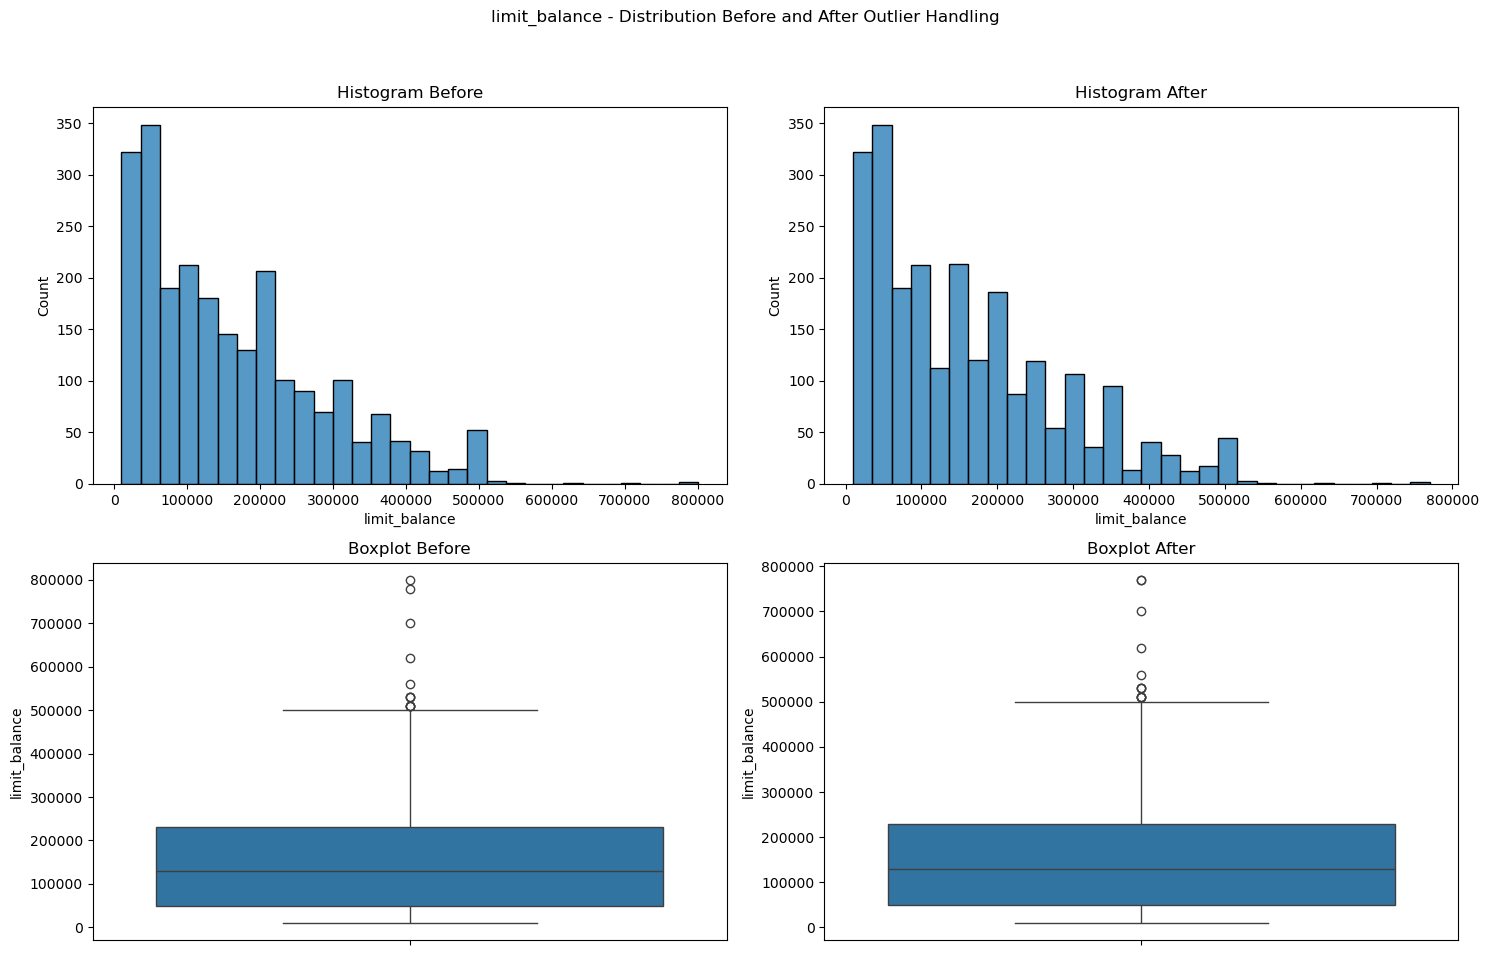

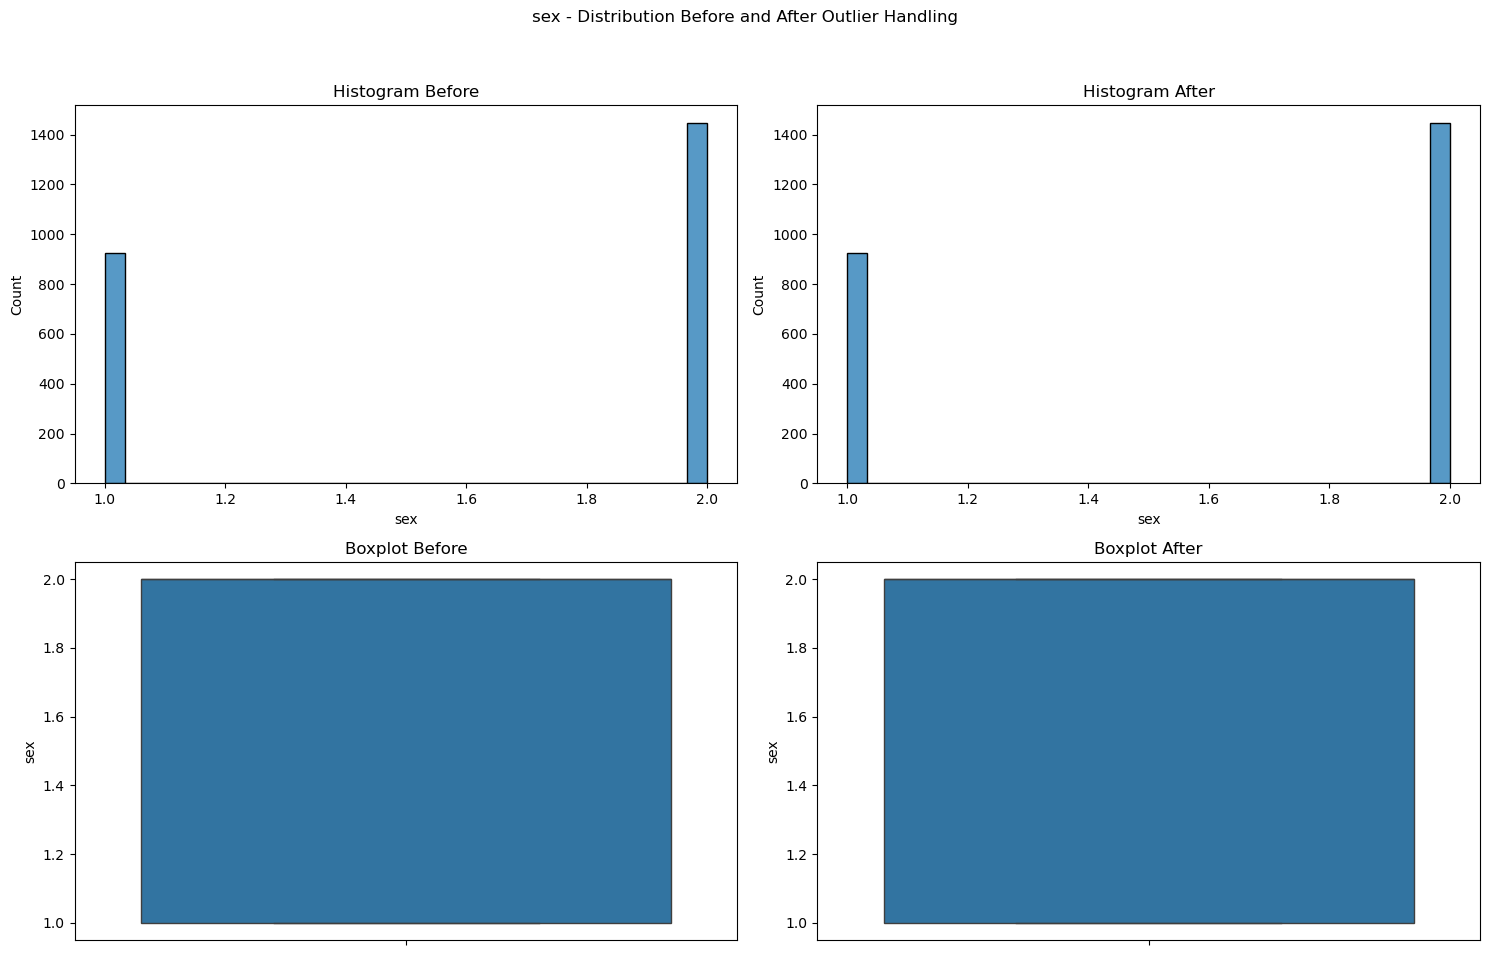

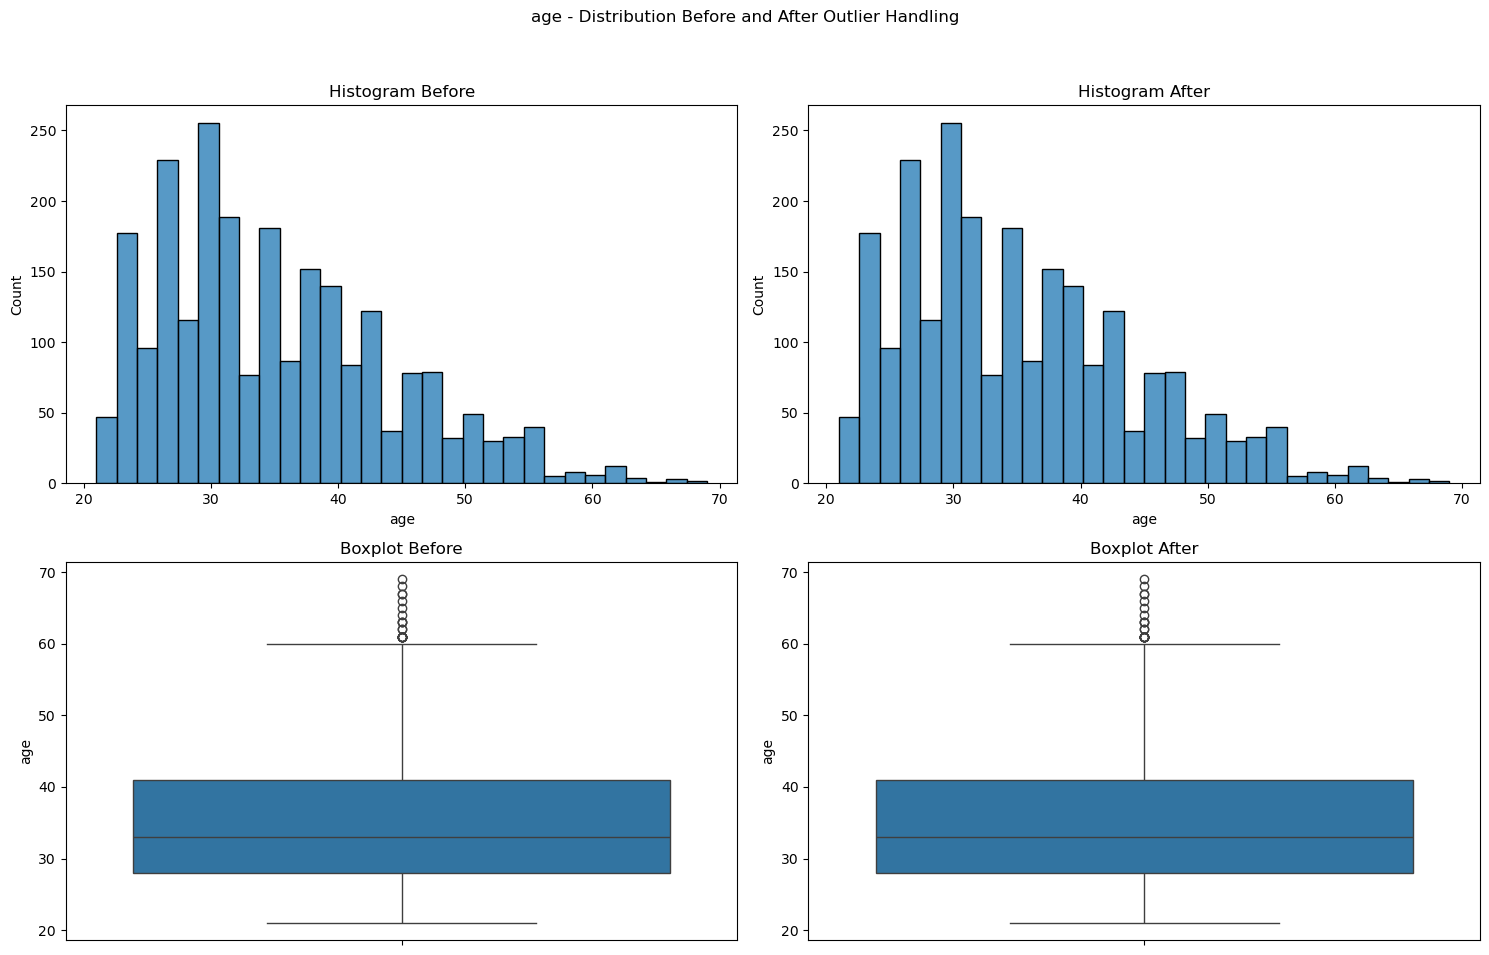

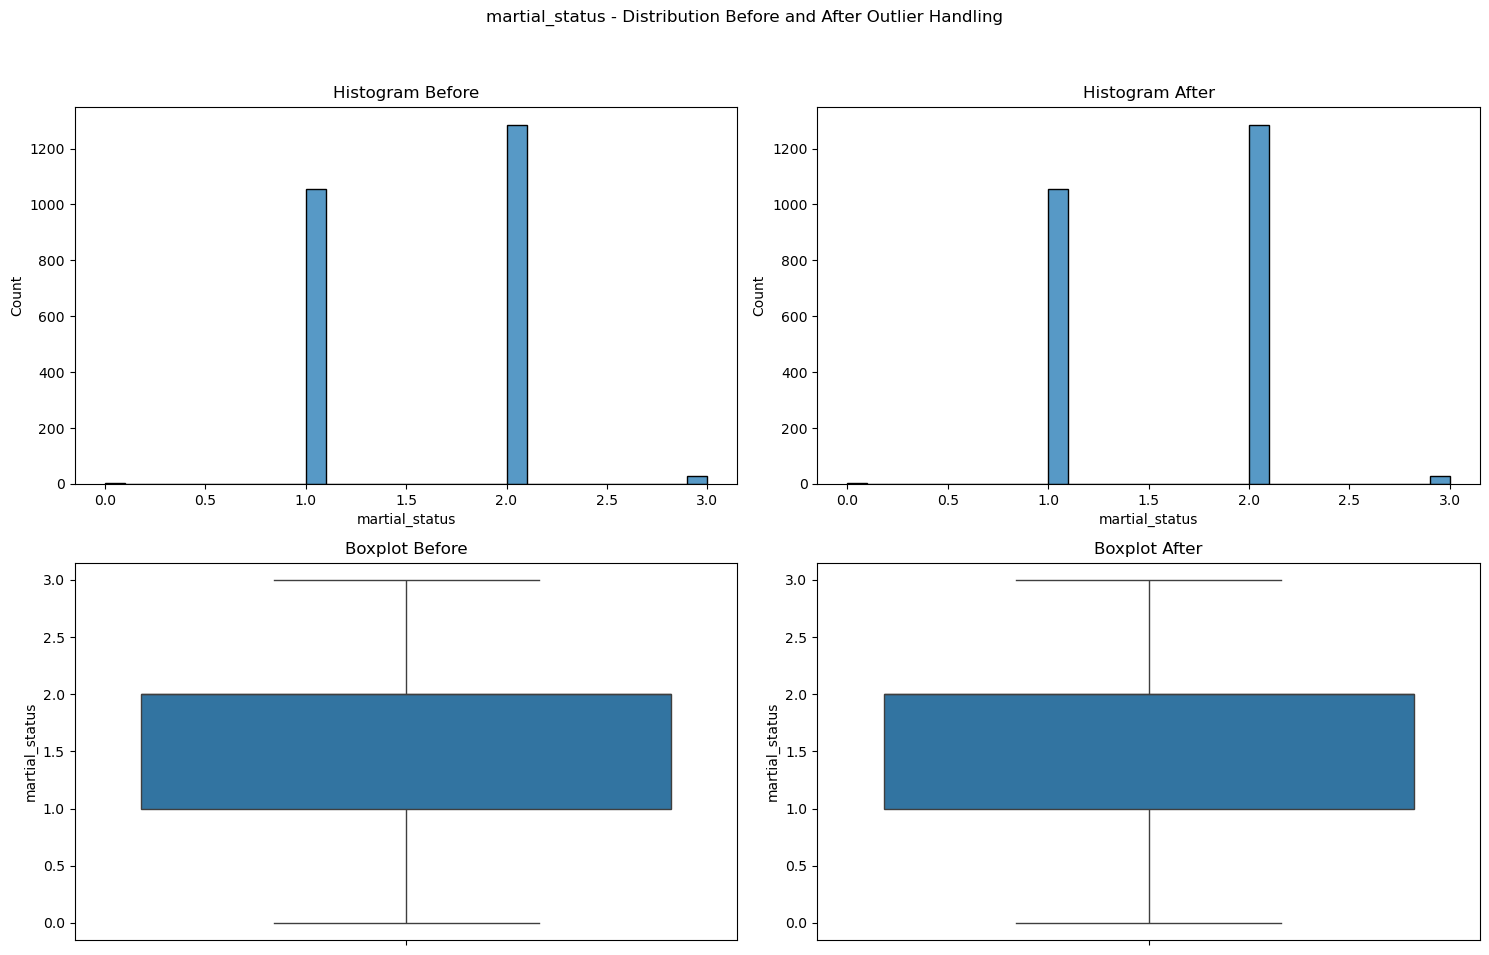

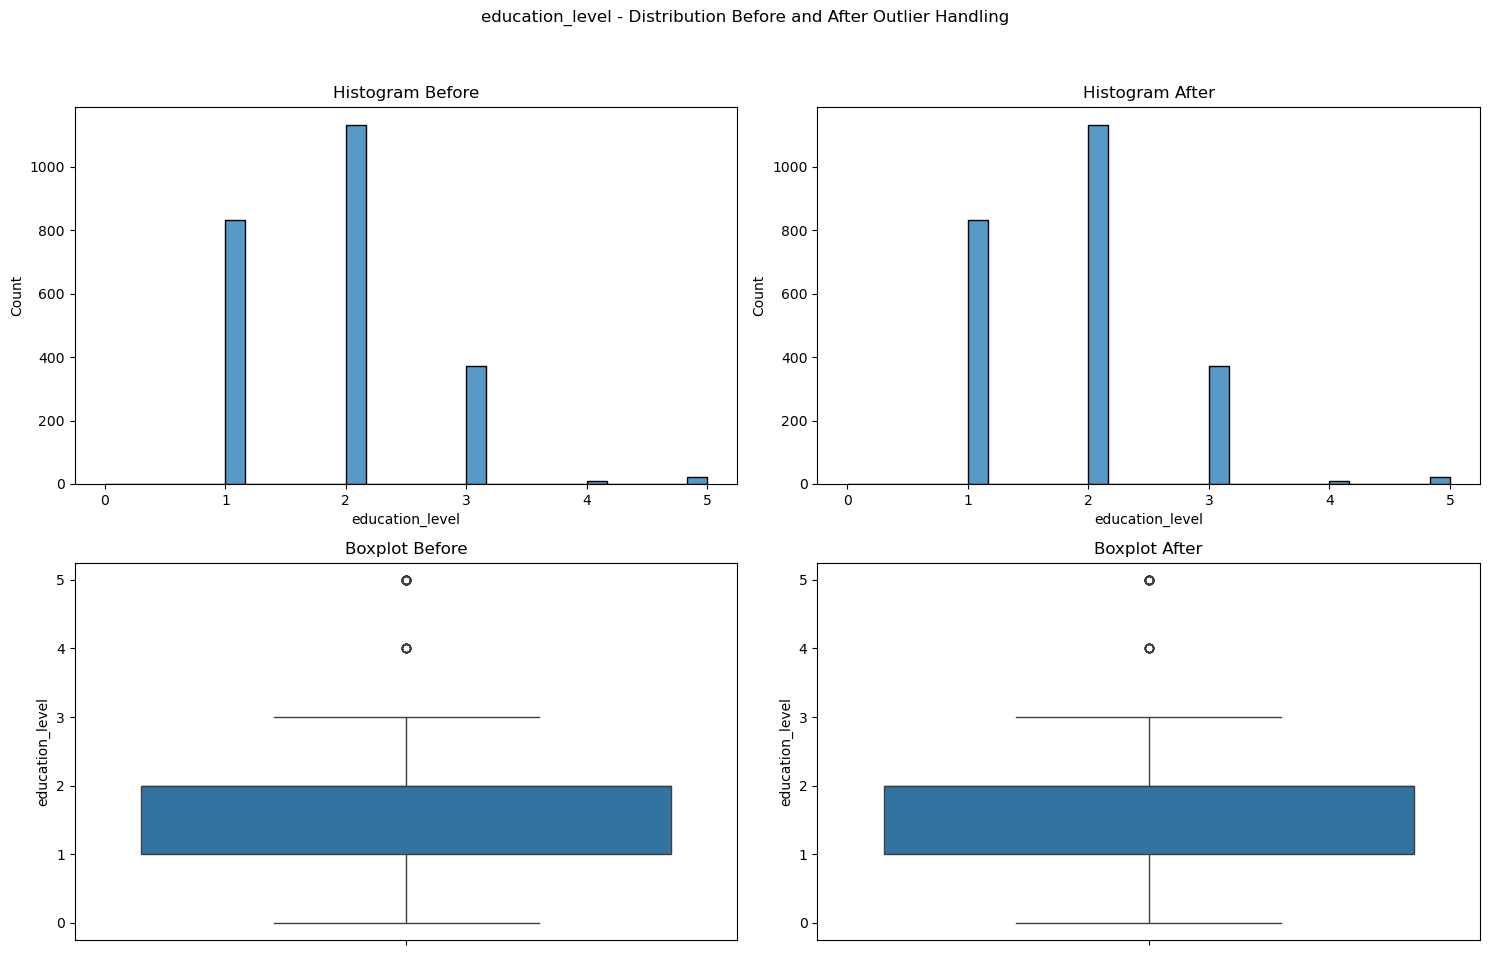

In [43]:
# Looping untuk memanggil fungsi outlierhandling
for i in numcol :
    outlierhandling(xtrain, xtrain_capped, i)

Dari hasil visualisasi sebelum dan sesudah outlier handling dapat terlihat jika hanya kolom limit_balance yang mengalami pengurangan outlier secara signifikan. Kemungkinan besar hal ini disebabkan karena banyak nilai ekstrim pada kolom limit_balance jauh lebih tinggi nilainya dibandingkan upper/lower bondnya dibandingkan nilai - nilai ekstrim pada kolom lain sehingga proses capping menjadi lebih signifikan pada kolom limit_balance.

### 5.4. Feature selection

Proses ini dilakukan untuk menyeleksi kolom - kolom agar dapat dijadikan sebagai feature. Kolom - kolom yang akan dijadikan sebagai feature harus memiliki ciri - ciri sebagai berikut :

1. Berdasarkan business domain dan knowledge kolom tersebut memang pernah mempengaruhi target atau kolom tersebut memang memiliki kemungkinan untuk mempengaruhi target

   Filtering ini didasarkan pada pengetahuan dan pengalaman empiris serta logika atas hubungan sebab akibat

2. Tidak memiliki multicollinearity dengan kolom lain 

   Artinya kolom tidak boleh memiliki korelasi yang signifikan dengan kolom lain (kecuali target). Hal ini untuk mencegah model kesulitan dalam menginterpretasi pengaruh dari masing - masing independen variable. Dalam memfilter multicollinearity kita akan menggunakan nilai Variance Inflation Factor (VIF) sebagai parameter. Nilai VIF yang baik adalah sebesar VIF <= 1, namun kali ini kita akan membuat batas nilai VIF tidak boleh atau sama dengan 5 (VIF <= 5). Perlu diketahui, proses seleksi menggunakan VIF juga harus menggunakan business domain/knowledge. Misalkan suatu kolom atau atribut memiliki nilai VIF lebih dari 5, namun berdasarkan pengalaman di dunia nyata, atribut tersebut beberapa kali dapat mempengaruhi target. Hal seperti ini juga harus dijadikan pertimbangan untuk menjustifikasi penghapusan kolom berdasarkan nilai VIF

3. Lolos uji korelasi

   Artinya kolom harus memiliki korelasi dengan target, jika tidak memiliki korelasi model akan memiliki performa yang buruk dan akurasi prediksinya menjadi buruk

4. Kolom hanya memiliki 1 unique values

   Kolom seperti ini tidak memiliki korelasi terhadap target karena tidak ada variasi nilai yang menggambarkan hubungan sebab akibat


#### 5.4.1. Uji korelasi

Tujuan dari uji korelasi adalah untuk melihat ada tidaknya korelasi dan seberapa mungkin terjadinya korelasi tersebut (signifikan atau tidak signifikan) berdasarkan koefisien korelasi dan p value. Sebelum menjalani uji korelasi, beberapa hal harus diterangkan :

1. Nilai koefisien korelasi menggambarkan seberapa kuat hubungan antara independent variable (kolom) dengan target. Nilai koefisien yang berada pada rentang 0 <= koefisien <= 0.1 memiliki arti hubungan yang sangat lemah atau tidak ada hubungan sama sekali, nilai korelasi 0.1 < koefisien <= 4 memiliki arti hubungan yang lemah, nilai korelasi 0.4 < koefisien <= 6 memiliki arti hubungan yang sedang, dan nilai korelasi 0.6 < koefisien <= 8 memiliki arti hubungan yang kuat, dan nilai korelasi 0.8 < koefisien <= 1 memiliki arti hubungan yang sangat kuat. "Dari hasil visualisasi scaterrplot antara target dengan beberapa kolom (pada bagian EDA), terlihat bahwa dari seluruh kolom yang divisualisasikan, tidak ada kolom yang menunjukan adanya hubungan korelasi sedang atau kuat. Dari hasil tersebut maka akan ditetapkan hanya ada 2 kategori korelasi yaitu tidak berkorelasi (koefisien <= 0.1) dan berkorelasi (koefisien > 0.1)"

2. Nilai P value menggambarkan seberapa mungkin (probabilitas) mendapatkan nilai hasil perhitungan korelasi "secara kebetulan". 

3. Hipotesis akan dibagi menjadi 2, yaitu : 
   - Hipotesis 0 : Nilai korelasi didapatkan karena kebetulan
   - Hipotesis 1 : Nilai korelasi didapatkan bukan karena kebetulan

4. Nilai alfa (a)/signfikansi adalah nilai batas untuk menentukan apakah hipotesis H0 diterima atau ditolak (terima hipotesis H1). Nilai alfa pada umumnya memiliki nilai 0.05. Artinya, jika P value > 0.05 maka nilai korelasi yang didapatkan merupakan kebetulan semata dan presentase mendapatkan nilai yang sama secara kebetulan sebesar %P value. Jika nilai P value < a, maka nilai korelasi yang didapatkan bukan karena kebetulan (tolak H0, terima H1) karena presentase mendapatkan nilai tersebut secara kebetulan berada di bawah 5%

5. Pada proses ini, kita akan membagi uji korelasi menjadi 2 jenis, yaitu uji korelasi data kategorik dan uji korelasi data numerik. Uji korelasi data kategorik akan menggunakan metode Kendall. Uji korelasi data numerik akan dibagi menjadi 2 jenis, yaitu uji yang menggunakan metode Pearson dan uji korelasi yang menggunakan metode Spearman. Uji korelasi Pearson diperuntukan untuk data - data yang terdistribusi normal (skewness <= 0.5) sementara uji korelasi Spearman diperuntukan untuk data - data yang terdistribusi tidak normal/skewed (skewness > 0.5)

6. Dari nilai koefisien dan P value maka hasil akan dibagi menjadi 4 :
   Kategori 1 : Tidak ada korelasi, H0 ditolak
      * P value < 0.05 dan 0 <= koefisien <= 0.1      : Tidak ada korelasi, H0 ditolak       -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di bawah 5%
      * P value < 0.05 dan -0.1 <= koefisien <= 0     : Tidak ada korelasi, H0 ditolak       -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di bawah 5%
   
   Kategori 2 : Tidak ada korelasi, H0 diterima
      * P value > 0.05 dan 0 <= koefisien <= 0.1      : Tidak ada korelasi, H0 diterima      -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di atas 5%
      * P value > 0.05 dan -0.1 <= koefisien <= 0     : Tidak ada korelasi, H0 diterima      -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di atas 5%
   
   Kategori 3 : Terdapat korelasi, H0 ditolak
      * P value < 0.05 dan koefisien > 0.1            : Korelasi positif, H0 ditolak         -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di bawah 5%
      * P value < 0.05 dan koefisien < -0.1           : Korelasi negatif, H0 ditolak         -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di bawah 5%
   
   Kategori 4 : Terdapat korelasi, H0 diterima
      * P value > 0.05 dan koefisien > 0.1            : Korelasi positif, H0 diterima        -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di atas 5%
      * P value > 0.05 dan koefisien < -0.1           : Korelasi negatif, H0 diterima        -> Probabilitas mendapatkan hasil seperti ini secara kebetulan di atas 5%


   Dari ke - 4 kategori tersebut, kolom yang akan kita jadikan feature adalah kolom - kolom yang mendapatkan kategori 3 yaitu "Terdapat korelasi baik positif maupun negatif dimana probabilitas untuk mendapatkan hasil yang sama secara kebetulan adalah dibawah 5%". Hal ini dilakukan karena kolom - kolom yang akan dijadikan sebagai feature harus benar - benar memiliki korelasi dan kondisi tersebut didapatkan bukan karena kebetulan semata.

In [44]:
# Membuat list data numerik dan data kategorik
numcol = xtrain.select_dtypes(include='float64').columns.tolist()
catcol = xtrain.select_dtypes(include='int64').columns.tolist()

# Cek hasil
print('Numerical Columns: ', numcol)
print('Categorical Columns: ', catcol)

Numerical Columns:  ['limit_balance', 'age', 'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']
Categorical Columns:  ['sex', 'education_level', 'martial_status', 'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr']


In [45]:
# Membuat dataframe kategorikal dan numerikal
xtrainnum = xtrain_capped[numcol]
xtraincat = xtrain_capped[catcol]

# Cek hasil kolom - kolom numerikal
xtrainnum.head()

,limit_balance,age,bill_amt_sept,bill_amt_aug,bill_amt_jul,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
21,290000.0,56.0,222000.0,226917.0,415700.0,232732.0,220460.0,224780.0,10013.0,8501.0,15018.0,10001.0,7997.0,7624.0
1388,260000.0,28.0,149814.0,184419.0,163036.0,159348.0,160198.0,104389.0,107000.0,0.0,5000.0,5000.0,6000.0,60000.0
567,60000.0,53.0,56765.0,57849.0,57432.0,27126.0,27579.0,29085.0,3000.0,4000.0,2000.0,2000.0,2000.0,2000.0
1594,150000.0,23.0,27414.0,10053.0,151996.0,152753.0,153844.0,151252.0,10096.0,156292.0,4700.0,5019.0,5300.0,5002.0
1017,130000.0,28.0,70952.0,69264.0,70184.0,8518.0,11296.0,6514.0,0.0,3000.0,2000.0,3000.0,2000.0,0.0


In [46]:
# Cek hasil kolom - kolom kategorikal
xtraincat.head()

,sex,education_level,martial_status,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr
21,1,1,1,0,0,0,0,0,0
1388,1,2,2,0,0,0,0,0,0
567,1,2,2,0,0,0,0,0,0
1594,2,2,2,0,0,0,0,0,0
1017,1,2,2,1,1,1,1,1,1


In [47]:
ytrain

21      0
1388    0
567     0
1594    0
1017    1
       ..
2014    1
2157    0
1931    1
1504    0
1712    0
Name: default_payment_next_month, Length: 2371, dtype: int64

##### Uji korelasi data kategorik

In [48]:
# Membuat list penampung nilai p value, nilai coefficient, magnitude, nama kolom, dan selected column
p_val = []
coef_val = []
magnitude = []
col_name = []
selected_cat = []

# Looping untuk uji korelasi Kendall
for col in xtraincat.columns :
    corr_tau, pval = stats.kendalltau(xtraincat[col], ytrain)
    
    # Memasukan hasil nilai uji kedalam list
    p_val.append(round(pval,4))
    coef_val.append(round(corr_tau,4))
    col_name.append(col)

    # Filtering hasil uji korelasi
    if (pval < 0.05) and (corr_tau > 0.1) :
        magnitude.append('Korelasi positif, H0 ditolak')
        selected_cat.append(col)
    elif (pval < 0.05) and (corr_tau < -0.1) :
        magnitude.append('Korelasi negatif, H0 ditolak')
        selected_cat.append(col)
    elif (pval > 0.05) and (corr_tau > 0.1) :
        magnitude.append('Korelasi positif, H0 diterima')
    elif (pval > 0.05) and (corr_tau < -0.1) :
        magnitude.append('Korelasi negatif, H0 diterima')
    elif (pval > 0.05) and ((corr_tau < 0.1) and (corr_tau >= 0)) :
        magnitude.append('Tidak ada korelasi, H0 diterima')
    elif (pval > 0.05) and ((corr_tau > -0.1) and (corr_tau <= 0)) :
        magnitude.append('Tidak ada korelasi, H0 diterima')
    elif (pval < 0.05) and ((corr_tau < 0.1) and (corr_tau >= 0)) :
        magnitude.append('Tidak ada korelasi, H0 ditolak')
    elif (pval < 0.05) and ((corr_tau > -0.1) and (corr_tau <= 0)) :
        magnitude.append('Tidak ada korelasi, H0 ditolak')



# Membuat dataframe hasil uji korelasi
ujikorelasi = pd.DataFrame({'Column' : col_name, 'Tau coefficient' : coef_val, 'P value' : p_val, 'Magnitude' : magnitude})

# Cek hasil
ujikorelasi.sort_values(by='P value')

,Column,Tau coefficient,P value,Magnitude
3,pay_sept,1.0000,0.0000,"Korelasi positif, H0 ditolak"
4,pay_aug,1.0000,0.0000,"Korelasi positif, H0 ditolak"
5,pay_jul,1.0000,0.0000,"Korelasi positif, H0 ditolak"
6,pay_jun,1.0000,0.0000,"Korelasi positif, H0 ditolak"
7,pay_may,1.0000,0.0000,"Korelasi positif, H0 ditolak"
8,pay_apr,1.0000,0.0000,"Korelasi positif, H0 ditolak"
1,education_level,0.0594,0.0023,"Tidak ada korelasi, H0 ditolak"
2,martial_status,-0.0349,0.0874,"Tidak ada korelasi, H0 diterima"
0,sex,-0.0249,0.2261,"Tidak ada korelasi, H0 diterima"


Uji korelasi ini dilakukan menggunakan metode korelasi kendall tau karena kolom - kolom yang diuji memiliki tipe nilai kategorik. Dari hasil uji tersebut, hanya kolom pay_n yang lolos uji atau memiliki korelasi terhadap target. Hasil ini masuk akal karena kolom tersebut menjelaskan telat tidaknya status pembayaran dari customer yang mana dapat menentukan gagal atau tidaknya customer tersebut dalam membayar tagihannya di bulan depan.

In [49]:
# Cek selected column
print(selected_cat)

['pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr']


##### Uji korelasi data numerik

Uji korelasi ini dikhususkan untuk kolom - kolom yang memiliki tipe data numerik. Proses ini menggunakan 2 metode korelasi yaitu metode Person untuk kolom - kolom yang nilainya terdistribusi secara normal dan metode Spearman untuk kolom - kolom yang nilainya tidak terdistribusi normal.

In [50]:
# Membuat list penampung nilai p value, nilai coefficient, magnitude, nama kolom, dan selected column
p_val = []
coef_val = []
magnitude = []
col_name = []
selected_num = []
corr = []
distribution = []

# Looping untuk uji korelasi Pearson (normal distribution)
for col in xtrainnum.columns :
    # if statement untuk filtering kolom dengan distribusi normal
    if abs(xtrainnum[col].skew()) < 0.5 :
        corr_r, pval_r = stats.pearsonr(xtrainnum[col], ytrain)
    
        # Memasukan hasil nilai uji kedalam list
        p_val.append(round(pval_r,4))
        coef_val.append(round(corr_r,4))
        col_name.append(col)
        corr.append('Pearson')
        distribution.append('Normal')

        # Filtering hasil uji korelasi
        if (pval_r < 0.05) and (corr_r > 0.1) :
            magnitude.append('Korelasi positif, H0 ditolak')
            selected_num.append(col)
        elif (pval_r < 0.05) and (corr_r < -0.1) :
            magnitude.append('Korelasi negatif, H0 ditolak')
            selected_num.append(col)
        elif (pval_r > 0.05) and (corr_r > 0.1) :
            magnitude.append('Korelasi positif, H0 diterima')
        elif (pval_r > 0.05) and (corr_r < -0.1) :
            magnitude.append('Korelasi negatif, H0 diterima')
        elif (pval_r > 0.05) and ((corr_r <= 0.1) and (corr_r >= 0)) :
            magnitude.append('Tidak ada korelasi, H0 diterima')
        elif (pval_r > 0.05) and ((corr_r >= -0.1) and (corr_r <= 0)) :
            magnitude.append('Tidak ada korelasi, H0 diterima')
        elif (pval_r < 0.05) and ((corr_r <= 0.1) and (corr_r >= 0)) :
            magnitude.append('Tidak ada korelasi, H0 ditolak')
        elif (pval_r < 0.05) and ((corr_r >= -0.1) and (corr_r <= 0)) :
            magnitude.append('Tidak ada korelasi, H0 ditolak')



    # else statement untuk filtering kolom dengan distribusi skewed
    else :
        corr_rho, pval_s = stats.spearmanr(xtrainnum[col], ytrain)
    
        # Memasukan hasil nilai uji kedalam list
        p_val.append(round(pval_s,4))
        coef_val.append(round(corr_rho,4))
        col_name.append(col)
        corr.append('Spearman')
        distribution.append('Skewed')

        # Filtering hasil uji korelasi
        if (pval_s < 0.05) and (corr_rho > 0.1) :
            magnitude.append('Korelasi positif, H0 ditolak')
            selected_num.append(col)
        elif (pval_s < 0.05) and (corr_rho < -0.1) :
            magnitude.append('Korelasi negatif, H0 ditolak')
            selected_num.append(col)
        elif (pval_s > 0.05) and (corr_rho > 0.1) :
            magnitude.append('Korelasi positif, H0 diterima')
            selected_num.append(col)
        elif (pval_s > 0.05) and (corr_rho < -0.1) :
            magnitude.append('Korelasi negatif, H0 diterima')
            selected_num.append(col)
        elif (pval_s > 0.05) and ((corr_rho <= 0.1) and (corr_rho >= 0)) :
            magnitude.append('Tidak ada korelasi, H0 diterima')
        elif (pval_s > 0.05) and ((corr_rho >= -0.1) and (corr_rho <= 0)) :
            magnitude.append('Tidak ada korelasi, H0 diterima')
        elif (pval_s < 0.05) and ((corr_rho <= 0.1) and (corr_rho >= 0)) :
            magnitude.append('Tidak ada korelasi, H0 ditolak')
        elif (pval_s < 0.05) and ((corr_rho >= -0.1) and (corr_rho <= 0)) :
            magnitude.append('Tidak ada korelasi, H0 ditolak')

# Membuat dataframe hasil uji korelasi
ujikorelasi_num = pd.DataFrame({'Column' : col_name, 'Distribusi' : distribution,'Korelasi' : corr, 'Coefficient' : coef_val, 'P value' : p_val, 'Magnitude' : magnitude})

# Cek hasil
ujikorelasi_num.sort_values(by='P value')

,Column,Distribusi,Korelasi,Coefficient,P value,Magnitude
0,limit_balance,Skewed,Spearman,-0.1708,0.0000,"Korelasi negatif, H0 ditolak"
8,pay_amt_sept,Skewed,Spearman,-0.1466,0.0000,"Korelasi negatif, H0 ditolak"
9,pay_amt_aug,Skewed,Spearman,-0.1499,0.0000,"Korelasi negatif, H0 ditolak"
10,pay_amt_jul,Skewed,Spearman,-0.1197,0.0000,"Korelasi negatif, H0 ditolak"
11,pay_amt_jun,Skewed,Spearman,-0.1306,0.0000,"Korelasi negatif, H0 ditolak"
12,pay_amt_may,Skewed,Spearman,-0.0951,0.0000,"Tidak ada korelasi, H0 ditolak"
13,pay_amt_apr,Skewed,Spearman,-0.1345,0.0000,"Korelasi negatif, H0 ditolak"
1,age,Skewed,Spearman,0.0284,0.1665,"Tidak ada korelasi, H0 diterima"
7,bill_amt_apr,Skewed,Spearman,0.0193,0.3481,"Tidak ada korelasi, H0 diterima"
2,bill_amt_sept,Skewed,Spearman,-0.0097,0.6378,"Tidak ada korelasi, H0 diterima"


Dari hasil uji korelasi Pearson dan Spearman, ***hanya kolom pay_amt_n (kecuali pada n = may)*** yang memiliki korelasi dengan target berdasarkan spesifikasi yang telah ditetapkan. 1 hal yang perlu dicatat, ***karena pay_amt_may memiliki tujuan yang sama seperti kolom - kolom pay_amt_n yang lain dan nilai korelasinya yang tidak terlalu jauh dengan nilai 0.1***, maka secara pertimbangan bisnis kolom tersebut akan tetap dimasukan kedalam kolom yang terseleksi.

In [51]:
# Memasukan kolom pay_amt_may kedalam selected columns
selected_num.append('pay_amt_may')

# Merubah posisi index kolom
selected_num[5] = selected_num[6]
selected_num[6] = 'pay_amt_apr'

# Cek selected column
print(selected_num)

['limit_balance', 'pay_amt_sept', 'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']


In [52]:
# Update kolom dataframe train
xtrainnum = xtrainnum[selected_num]
xtraincat = xtraincat[selected_cat]

# Update kolom dataframe test
xtestnum = xtest_capped[selected_num]
xtestcat = xtest_capped[selected_cat]

# Cek hasil dataframe numerik
xtrainnum

,limit_balance,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
21,290000.0,10013.0,8501.0,15018.0,10001.0,7997.0,7624.0
1388,260000.0,107000.0,0.0,5000.0,5000.0,6000.0,60000.0
567,60000.0,3000.0,4000.0,2000.0,2000.0,2000.0,2000.0
1594,150000.0,10096.0,156292.0,4700.0,5019.0,5300.0,5002.0
1017,130000.0,0.0,3000.0,2000.0,3000.0,2000.0,0.0
...,...,...,...,...,...,...,...
2014,50000.0,0.0,0.0,0.0,0.0,0.0,0.0
2157,90000.0,0.0,1000.0,1000.0,1052.0,71062.0,3000.0
1931,150000.0,5950.0,0.0,10000.0,0.0,20000.0,0.0
1504,160000.0,0.0,0.0,700.0,0.0,0.0,0.0


In [53]:
# Cek hasil dataframe kategorik
xtraincat

,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr
21,0,0,0,0,0,0
1388,0,0,0,0,0,0
567,0,0,0,0,0,0
1594,0,0,0,0,0,0
1017,1,1,1,1,1,1
...,...,...,...,...,...,...
2014,1,1,1,1,1,1
2157,0,0,0,0,0,0
1931,1,1,1,1,1,1
1504,0,0,0,0,0,0


#### 5.4.2. VIF selection

Fokus pada proses seleksi ini adalah untuk menghilangkan kolom - kolom yang memiliki multicollinearity. Sifat multicollinearity dapat direpresentasikan dengan nilai Variance Inflation Factor (VIF). Akinwande, dkk (2015) telah mengkategorisasikan nilai VIF beserta tingkat multicollinearitynya sebagai berikut :

1. Nilai VIF <= 1 menunjukan tidak adanya multicollinearity antar predictor

2. Nilai VIF yang berada pada rentang 1 < VIF < 5 menunjukan adanya moderate multicollinearity 

3. Nilai VIF yang berada pada rentang 5 <= VIF <= 10 menunjukkan multicollinearity yang tinggi serta kemungkinan besar dapat menimbulkan masalah pada model regresi

4. Nilai VIF melebihi 10 maka kemungkinan besar koefisien regresi tidak dapat diestimasi dengan baik (kemungkinan nilai ekstrim pada koefisien akan muncul)

Dari penjelasan di atas, maka akan dipilih batas nilai VIF dari kolom adalah kurang dari atau sama dengan 4 (VIF <= 4), artinya kita masih mentoleransi adanya kolom yang memiliki moderate multicollinearity. Namun sebagai catatan, dibutuhkan pertimbangan bisnis untuk menjustifikasi penghapusan kolom beradasarkan nilai VIF.


In [54]:
xtrain_vif = xtraincat.merge(xtrainnum, left_index=True, right_index=True)

Sebagai catatan, untuk menghindari pembagian dengan 0 (hasil nilai infinite) maka hanya kolom - kolom numerik yang akan dicek nilai VIF nya.

In [55]:
# Membuat fungsi untuk menghitung VIF
def calc_vif(x):
    global selected_num
    vif = pd.DataFrame()
    vif["variables"] = x[selected_num].columns
    vif["VIF"] = [variance_inflation_factor(x[selected_num].values, i) for i in range(x[selected_num].shape[1])]
    return(vif)

# Menghitung nilai VIF
vif = calc_vif(xtrain_vif)

# Cek hasil
vif

,variables,VIF
0,limit_balance,1.547827
1,pay_amt_sept,1.398811
2,pay_amt_aug,1.375292
3,pay_amt_jul,1.369381
4,pay_amt_jun,1.216346
5,pay_amt_may,1.141562
6,pay_amt_apr,1.180376


Kita dapat lihat hasil dari perhitungan VIF di atas bahwa nilai - nilai VIF pada masing - masing kolom masih masuk dalam syarat non multicollinearity (VIF < 5) sehingga tidak ada kolom yang dihapus dalam proses ini

### 5.5. Feature scaling

Proses ini bertujuan untuk menyamakan skala nilai dari feature bertipe data numerik. Penyamaan skala diperlukan agar tidak ada feature yang mendominasi perhitungan model karena skala nilainya yang terlalu besar dibandingkan skala nilai feature numerik lain. Jika salah satu feature nilai - nilainya mendominasi perhitungan dibandingkan nilai - nilai feature lain, maka besar kemungkinan prediksi model akan menjadi bias karena prediksi model sebagian besar dipengaruhi oelh nilai - nilai yang jauh lebih besar dibandingkan nilai - nilai lainnya.

Terdapat 3 metode scaling, yaitu :

1. MinMax Scaler
   Digunakan untuk data yang tidak memiliki distribusi normal. Kekurangan dari metode ini adalah bahwa metode ini sensitif terhadap outliers

2. Standard Scaler
   Digunakan untuk data yang memiliki distribusi normal. Kekurangan dari metode ini adalah bahwa metode ini sensitif terhadap outliers dan tidak cocok terhadap data berdistribusi skewed

3. Robust Scaler
   Digunakan untuk data yang memiliki banyak outlier karena metode ini hanya menggunakan IQR dan median untuk melakukan scaling. Kekurangan dari metode ini adalah bahwa metode ini mengabaikan mean dalam perhitungannya (karena mean sensitif terhadap outliers)

Sebelum melakukan scaling, kita akan melihat outliers dari masing - masing feature numerik. Hal ini bertujuan agar kita tidak salah dalam memilih metode scaling dan agar dapat memilih metode yang sesuai dengan keadaan data feature. Pertama - tama saya akan membuat dataframe baru untuk menggabungkan dataframe numerik dengan dataframe kategorik. Penggabungan dilakukan karena pada kolom kategorik datanya sudah berupa numerik (sudah diencoding) sehingga proses scalling akan dilakukan pada seluruh kolom di dataframe.

In [56]:
# Membuat dataframe baru untuk proses scaling
xtrain_scaling = xtraincat.merge(xtrainnum, left_index=True, right_index=True)
xtest_scalling = xtestcat.merge(xtestnum, left_index=True, right_index=True)

# Mengubah posisi kolom limit_balance pada xtrain_scalling
limit_balance = xtrain_scaling['limit_balance']
xtrain_scaling = xtrain_scaling.drop(columns=['limit_balance'])
xtrain_scaling.insert(0, 'limit_balance', limit_balance)

# Cek hasil
xtrain_scaling.head()

,limit_balance,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
21,290000.0,0,0,0,0,0,0,10013.0,8501.0,15018.0,10001.0,7997.0,7624.0
1388,260000.0,0,0,0,0,0,0,107000.0,0.0,5000.0,5000.0,6000.0,60000.0
567,60000.0,0,0,0,0,0,0,3000.0,4000.0,2000.0,2000.0,2000.0,2000.0
1594,150000.0,0,0,0,0,0,0,10096.0,156292.0,4700.0,5019.0,5300.0,5002.0
1017,130000.0,1,1,1,1,1,1,0.0,3000.0,2000.0,3000.0,2000.0,0.0


In [57]:
# Mengubah posisi kolom limit_balance pada xtest_scalling
limit_balance = xtest_scalling['limit_balance']
xtest_scalling = xtest_scalling.drop(columns=['limit_balance'])
xtest_scalling.insert(0, 'limit_balance', limit_balance)

# Cek hasil
xtest_scalling.head()

,limit_balance,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
2410,160000.0,0,0,0,0,0,0,2122.0,5822.0,5524.0,615.0,25139.0,2100.0
700,100000.0,0,0,0,0,0,0,4589.0,4516.0,3645.0,3649.0,3724.0,3236.0
1128,150000.0,0,0,0,0,0,0,5210.0,5212.0,4610.0,706.0,1200.0,0.0
2466,30000.0,0,0,0,0,0,0,913.0,10773.0,916.0,3091.0,700.0,0.0
2310,30000.0,0,0,0,0,0,0,1013.0,1900.0,0.0,2558.0,2829.0,3000.0


In [58]:
# Membuat fungsi untuk menghitung presentase outliers
def outlier(x, variable) :
    q1 = x[variable].quantile(0.25)
    q3 = x[variable].quantile(0.75)
    iqr = q3-q1

    up_bound = q3 + 1.5*iqr
    low_bound = q1 - 1.5*iqr

    outlier = x[variable][(x[variable]<low_bound) | (x[variable]>up_bound)]

    return f'Percentage of outliers of variable {variable} =  {len(outlier)*100/len(x[variable]):.2f}%\nSkewness {variable} = {x[variable].skew()}'

for col in xtrain_scaling :
    print(outlier(xtrain_scaling,col))

Percentage of outliers of variable limit_balance =  0.51%
Skewness limit_balance = 1.0078803785299606
Percentage of outliers of variable pay_sept =  21.51%
Skewness pay_sept = 1.3876245143975514
Percentage of outliers of variable pay_aug =  21.51%
Skewness pay_aug = 1.3876245143975514
Percentage of outliers of variable pay_jul =  21.51%
Skewness pay_jul = 1.3876245143975514
Percentage of outliers of variable pay_jun =  21.51%
Skewness pay_jun = 1.3876245143975514
Percentage of outliers of variable pay_may =  21.51%
Skewness pay_may = 1.3876245143975514
Percentage of outliers of variable pay_apr =  21.51%
Skewness pay_apr = 1.3876245143975514
Percentage of outliers of variable pay_amt_sept =  9.11%
Skewness pay_amt_sept = 12.114247164249644
Percentage of outliers of variable pay_amt_aug =  9.36%
Skewness pay_amt_aug = 28.10102671697262
Percentage of outliers of variable pay_amt_jul =  8.86%
Skewness pay_amt_jul = 8.049597102861508
Percentage of outliers of variable pay_amt_jun =  8.77%


Dari hasil di atas dapat terlihat bahwa hampir seluruh kolom memiliki presentase outlier di atas 5 % dan seluruh kolom memiliki distribusi yang tidak normal. Oleh karena itu, proses scalling akan menggunakan Robust Scaller.

In [59]:
original_index = xtrainnum.index
original_index2 = xtestnum.index

# Membuat object scaler
scaler = RobustScaler()


# Fit transformation dan proses scaling
xtrain_scaled = scaler.fit_transform(xtrain_scaling)
xtest_scaled = scaler.transform(xtest_scalling)

# Mengambil nama kolom
scaled_columns = scaler.get_feature_names_out(xtrain_scaling.columns)

# Cek sebelum scaling
xtrain_scaling

,limit_balance,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
21,290000.0,0,0,0,0,0,0,10013.0,8501.0,15018.0,10001.0,7997.0,7624.0
1388,260000.0,0,0,0,0,0,0,107000.0,0.0,5000.0,5000.0,6000.0,60000.0
567,60000.0,0,0,0,0,0,0,3000.0,4000.0,2000.0,2000.0,2000.0,2000.0
1594,150000.0,0,0,0,0,0,0,10096.0,156292.0,4700.0,5019.0,5300.0,5002.0
1017,130000.0,1,1,1,1,1,1,0.0,3000.0,2000.0,3000.0,2000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,50000.0,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0
2157,90000.0,0,0,0,0,0,0,0.0,1000.0,1000.0,1052.0,71062.0,3000.0
1931,150000.0,1,1,1,1,1,1,5950.0,0.0,10000.0,0.0,20000.0,0.0
1504,160000.0,0,0,0,0,0,0,0.0,0.0,700.0,0.0,0.0,0.0


In [60]:
# Cek setelah scalling
xtrain_scaled

array([[ 0.88888889,  0.        ,  0.        , ...,  2.26570769,
         1.75341709,  1.56860679],
       [ 0.72222222,  0.        ,  0.        , ...,  0.90840005,
         1.20198813, 15.36265473],
       [-0.38888889,  0.        ,  0.        , ...,  0.09417831,
         0.09747342,  0.08743745],
       ...,
       [ 0.11111111,  1.        ,  1.        , ..., -0.44863618,
         5.06778959, -0.43929418],
       [ 0.16666667,  0.        ,  0.        , ..., -0.44863618,
        -0.45478393, -0.43929418],
       [-0.66666667,  0.        ,  0.        , ..., -0.44863618,
        -0.31671959,  0.08743745]])

In [61]:
# Buat dataframe baru hasil scalling
xtrain_final = pd.DataFrame(xtrain_scaled,columns=scaled_columns, index=original_index)
xtest_final = pd.DataFrame(xtest_scaled,columns=scaled_columns,index=original_index2)

# Cek hasil
xtrain_final


,limit_balance,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
21,0.888889,0.0,0.0,0.0,0.0,0.0,0.0,1.938950,1.562361,3.283228,2.265708,1.753417,1.568607
1388,0.722222,0.0,0.0,0.0,0.0,0.0,0.0,26.008190,-0.545500,0.756620,0.908400,1.201988,15.362655
567,-0.388889,0.0,0.0,0.0,0.0,0.0,0.0,0.198536,0.446318,0.000000,0.094178,0.097473,0.087437
1594,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,1.959548,38.207786,0.680958,0.913557,1.008698,0.878062
1017,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,-0.545973,0.198364,0.000000,0.365586,0.097473,-0.439294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014,-0.444444,1.0,1.0,1.0,1.0,1.0,1.0,-0.545973,-0.545500,-0.504414,-0.448636,-0.454784,-0.439294
2157,-0.222222,0.0,0.0,0.0,0.0,0.0,0.0,-0.545973,-0.297545,-0.252207,-0.163116,19.167472,0.350803
1931,0.111111,1.0,1.0,1.0,1.0,1.0,1.0,0.930637,-0.545500,2.017654,-0.448636,5.067790,-0.439294
1504,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,-0.545973,-0.545500,-0.327869,-0.448636,-0.454784,-0.439294


In [62]:
# List untuk menampung kolom
selected_columns = xtrain_final.columns.to_list()

# 6. Model definition

Pada problem binary classification ini, ada 3 model yang akan ditrial terlebih dahulu di mode defaultnya (tanpa hyperparameter). Proses trial dilakukan untuk menyeleksi satu model terbaik berdasarkan nilai matriks evaluasinya dan pertimbangan kelemahan dari model itu sendiri. Ketiga model tersebut antara lain adalah Logistic Regression, Super Vector Machine (SVM), dan K-Nearest Neighbours (KNN). Berikut adalah deskripsi dan alasan pemilihan ketiga model tersebut :


1. Logistic Regression

      Model ini memanfaatkan komposisi fungsi yang mengambil hasil dari fungsi regresi linear ke dalam operasi fungsi sigmoid agar dapat menghasilkan output berupa probabilitas 0 atau 1 (memisahkkan 2 kelas yang berbeda). Alasan memasukan model ini kedalam proses trial adalah karena model ini dapat digunakan untuk melakukan binary classification. Namun yang perlu diperhatikan adalah, karena dalam proses matematisnya model ini menggunakan hasil regressi linear, maka model ini sangat sensitif terhadap ouliers. Hal ini perlu dijadikan pertimbangan ketika melakukan seleksi model


2. KNN

      Model ini menggunakan jarak terdekat antara point target dengan point - point dari kelas tertentu untuk melakukan klasifikasi. Model ini menggunakan hyperparameter 'K' yang menentukan berapa banyak point - point terdekat yang akan digunakan untuk melakukan klasifikasi berdasarkan jarak. Model ini tidak menggunakan asumsi distribusi normal pada data, sehingga sangat cocok untuk data yang tidak berdistribusi normal (skewed) seperti data yang kita miliki. Hal yang perlu diperhatikan adalah, karena KNN menggunakan jarak untuk melakukan klasifikasi, maka model ini sangat sensitif terhadap outliers. Sama seperti logistic linear, jumlah outlier pada data kita perlu dijadikan pertimbangan ketika melakukan seleksi model
      

3. SVM

      Model yang memanfaatkan decisions boundary line/hyperplane untuk melakukan klasifikasi. Hyperplane adalah baris yang dapat memisahkan 2 atau lebih kelas berdasarkan support vectornya (point kelas terdekat dengan hyperplane). Model ini dapat melakukan kelasifikasi pada data yang memiliki hubungan linear atau non linear antar dependent dan independent variablenya. Jika hubungannya non linear, maka model ini akan menggunakan kernel untuk membuat hyperplanenya. Ada 3 jenis kernel pada model ini yaitu RBF, Polynomial, dan Linear. ***Pada klasifikasi kali ini kita akan menggunakan kernel RBF sebagai model defaultnya karena model ini tidak memiliki asumsi distribusi data dan model ini juga lebih robust terhadap oulier***. Proses hypertuning (jika model ini terpilih) akan menggunakan hyperparameter "C" dan "Gamma"


Adapun alur kerja dalam pemilihan model adalah sebagai berikut :

1. Model training

2. Perbandingan performa model pada mode default

3. Cross validation dan pemilihan model
      
4. Hyperparameter tuning 


# 7. Model training

In [63]:
logreg = LogisticRegression()
logreg.fit(xtrain_final, ytrain)

knn = KNeighborsClassifier()
knn.fit(xtrain_final, ytrain)

svm = SVC()
svm.fit(xtrain_final, ytrain)

# svm_linear.fit(xtrain_final, ytrain)
# svm_poly.fit(xtrain_final, ytrain)
# svm_rbf.fit(xtrain, ytrain)

SVC()

# 8. Model evaluation

Karena pada kasus ini kita ingin memprediksi gagal atau tidaknya customer dalam membayar tagihan kredit berdasarkan karakter - karakternya (feature), maka matriks evaluasi yang digunakan adalah nilai recall. Alasannya, karena kita ingin meminimalkan false negative, dimana pada nilai tersebut menggambarkan customer yang dianggap dapat membayar tagihan kredit di bulan depan namun pada kenyataanya customer tersebut gagal membayar tagihannya. False negative dapat memberikan kerugian pada perusahaan karena memungkinkan perusahaan tersebut memberikan balance terus menerus pada customer yang memiliki potensi tinggi gagal bayar. Hal yang perlu disepakati adalah :

1. Terdapat 2 kelas, customer yang gagal bayar di bulan depan (1 atau positif) dan customer yang tidak gagal bayar di bulan depan (0 atau negatif)

      
2. Terdapat 4 kemungkinan hasil prediksi :
      
      - True positif             : Dari hasil prediksi customer tersebut tergolong dalam kelas 1 dan dari data aktualnya customer tersebut memang tergolong dalam kelas 1
      - False positif            : Dari hasil prediksi customer tersebut tergolong dalam kelas 1 namun dari data aktualnya customer tersebut tergolong dalam kelas 0
      - True negative            : Dari hasil prediksi customer tersebut tergolong dalam kelas 0 dan dari data aktualnya customer tersebut memang tergolong dalam kelas 0
      - False negatif            : Dari hasil prediksi customer tersebut tergolong dalam kelas 0 namun dari data aktualnya customer tersebut tergolong dalam kelas 1

### 8.1 Logistic regression

Classification report y train Logistic Regression : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1861
           1       1.00      1.00      1.00       510

    accuracy                           1.00      2371
   macro avg       1.00      1.00      1.00      2371
weighted avg       1.00      1.00      1.00      2371


Classification report y test logreg : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       125

    accuracy                           1.00       593
   macro avg       1.00      1.00      1.00       593
weighted avg       1.00      1.00      1.00       593



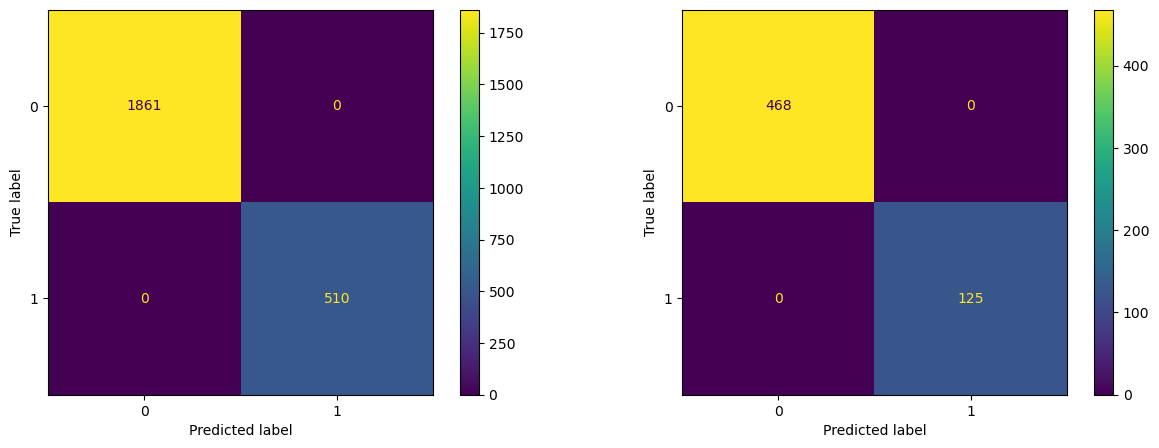

In [64]:
# Prediksi nilai y train dan y test menggunakan metode logistic regression
y_pred_train_logreg = logreg.predict(xtrain_final)
y_pred_test_logreg = logreg.predict(xtest_final)

# Menampilkan classification report hasil prediksi dataset training
print('Classification report y train Logistic Regression : ')
print(f'{classification_report(ytrain, y_pred_train_logreg)}\n')

# Menampilkan classification report hasil prediksi dataset test
print('Classification report y test logreg : ')
print(f'{classification_report(ytest, y_pred_test_logreg)}')

# Menampilkan confussion matrix hasil prediksi dataset training
fig, ax =plt.subplots(1,2, figsize = (15,5))
confuscm_train = confusion_matrix(ytrain, y_pred_train_logreg)
display_train = ConfusionMatrixDisplay(confusion_matrix=confuscm_train)
display_train.plot(ax=ax[0])

# Menampilkan confussion matrix hasil prediksi dataset test
confuscm_test = confusion_matrix(ytest, y_pred_test_logreg)
display_test = ConfusionMatrixDisplay(confusion_matrix=confuscm_test)
display_test.plot(ax=ax[1])

Berdasarkan hasil prediksi dataset training dan dataset test, didapatkan nilai recall dari kedua prediksi tersebut sebesar 1. Hal ini memberikan kesimpulan sebagai berikut:

1. Tidak terjadi overfitting pada prediksi model, artinya model dapat menghasilkan akurasi yang sama ketika diberika dataset yang berbeda dari dataset training

2. Dari seluruh data aktual customer yang mengalami gagal bayar, model berhasil menggolongkan seluruh customer tersebut sesuai dengan kelas aktualnya (gagal bayar di bulan depan) dengan presentase keberhasilan sebesar 100 % dari data aktual seluruh orang yang mengalami gagal bayar

3. Berdasarkan confussion matrix dataset test, model berhasil memprediksi 125 orang masuk dalam kelas gagal bayar (recall 100 %) dan berhasil memprediksi 468 orang masuk dalam kelas tidak gagal bayar (recall 100%)

Untuk mengecek apakah hasil di atas valid, maka kita akan melakukan cross validation pada model ini. Alasannya adalah, datasset training yang digunakan masih memiliki banyak outliers pada mayoritas fiturnya. Sementara kita tahu bahwa logistic linier sangat rentan terhadap outliers, sehingga kemungkinan besar nilai recall aktualnya tidak sebesar nilai recall hasil prediksi di atas.

***Note*** :
Berdasarkan confussion matrix dataset test, model berhasil memprediksi 468 orang sebagai true positives (recall 100 %) dan berhasil memprediksi 125 orang sebagai true negative (recall 100%). Hal ini kemungkinan disebabkan karena terjadi pembulatan pada hasil perhitungan confussion matrix

### 8.2. KNN

In [65]:
# Prediksi nilai y train dan y test menggunakan metode KNN
y_pred_train_knn = knn.predict(xtrain_final)
y_pred_test_knn = knn.predict(xtest_final)

Classification report y train KNN : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1861
           1       1.00      0.95      0.98       510

    accuracy                           0.99      2371
   macro avg       0.99      0.98      0.98      2371
weighted avg       0.99      0.99      0.99      2371


Classification report y test KNN : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       468
           1       1.00      0.94      0.97       125

    accuracy                           0.99       593
   macro avg       0.99      0.97      0.98       593
weighted avg       0.99      0.99      0.99       593



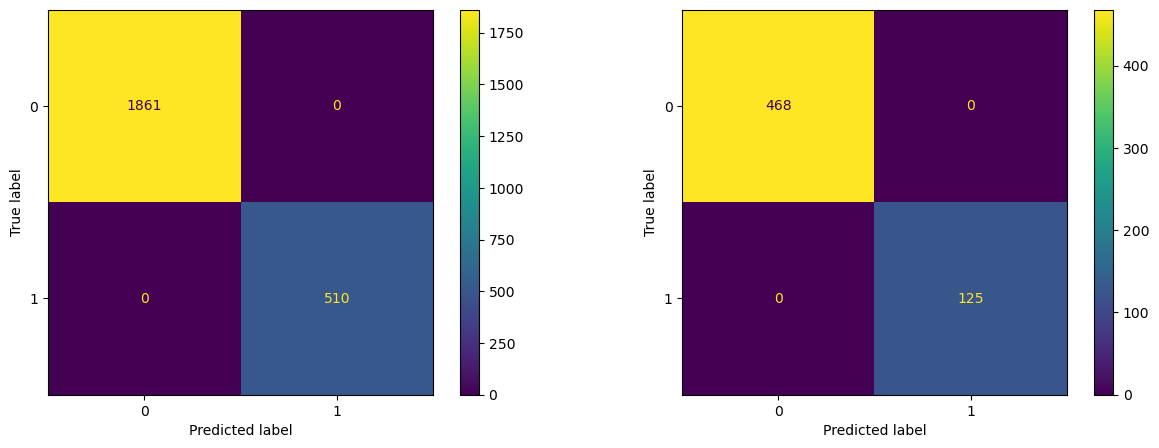

In [66]:
# Menampilkan classification report hasil prediksi dataset training
print('Classification report y train KNN : ')
print(f'{classification_report(ytrain, y_pred_train_knn)}\n')

# Menampilkan classification report hasil prediksi dataset test
print('Classification report y test KNN : ')
print(f'{classification_report(ytest, y_pred_test_knn)}')

# Menampilkan confussion matrix hasil prediksi dataset training
fig, ax =plt.subplots(1,2, figsize = (15,5))
confuscm_train_knn = confusion_matrix(ytrain, y_pred_train_knn)
display_train_knn = ConfusionMatrixDisplay(confusion_matrix=confuscm_train)
display_train.plot(ax=ax[0])

# Menampilkan confussion matrix hasil prediksi dataset test
confuscm_test_knn = confusion_matrix(ytest, y_pred_test_knn)
display_test_knn = ConfusionMatrixDisplay(confusion_matrix=confuscm_test)
display_test_knn.plot(ax=ax[1])



Berdasarkan hasil prediksi dataset training, dapat diambil kesimpulan sebagai berikut :

1. Nilai recall pada kelas positif pada dataset training sebesar 0.95. Sementara itu, berdasarkan hasil prediksi dataset test, didapatkan nilai recall sebesar 0.94. Artinya, terjadi sedikit overfitting pada prediksi model karena keberhasilan model dalam memprediksi orang yang gagal bayar dari seluruh elemen pada kelas gagal bayar cenderung sedikit lebih akurat pada dataset training dibandingkan hasil prediksi pada dataset test

2. Berdasarkan confussion matrix dataset test, model berhasil memprediksi 125 orang masuk dalam kelas gagal bayar (recall 100 %) dan berhasil memprediksi 468 orang masuk dalam kelas tidak gagal bayar (recall 100%). Nilai ini jika dihubungkan pada nilai recall hasilnya akan membingungkan, karena hasil yang ditunjukan pada confussion matrix nilai recallnya mencapai 100 % pada kedua dataset. Kemungkinan hal ini terjadi karena adanya pembulatan pada confussion matrix

Hasil prediksi model KNN akan kita validasi dengan metode cross validation. Alasannya sama seperti pada model logistic linier dimana dengan data yang memiliki banyak outliers, kemungkinan besar nilai recallnya tidak sebesar nilai recall hasil prediksi


### 8.3. SVM

In [67]:
# Prediksi y train dan y test menggunakan metode SVM
ytrain_svm = svm.predict(xtrain_final)
ytest_svm = svm.predict(xtest_final)

Classification report y train SVC RBF : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1861
           1       1.00      0.97      0.99       510

    accuracy                           0.99      2371
   macro avg       1.00      0.99      0.99      2371
weighted avg       0.99      0.99      0.99      2371

Classification report y test SVC RBF : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       468
           1       1.00      0.96      0.98       125

    accuracy                           0.99       593
   macro avg       0.99      0.98      0.99       593
weighted avg       0.99      0.99      0.99       593



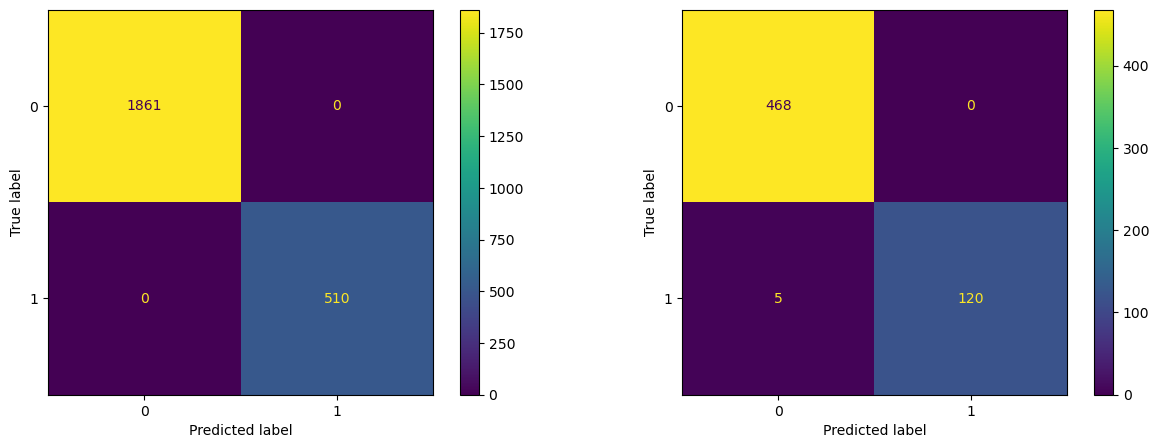

In [68]:
# Menampilkan classification report pada dataset training
print('Classification report y train SVC RBF : ')
print(f'{classification_report(ytrain, ytrain_svm)}')

# Menampilkan classification report pada dataset test
print('Classification report y test SVC RBF : ')
print(f'{classification_report(ytest, ytest_svm)}')

# Menampilkan confussion matrix hasil prediksi dataset training
fig, ax =plt.subplots(1,2, figsize = (15,5))
confusvc_train_rbf = confusion_matrix(ytrain, ytrain_svm)
display_train_rbf = ConfusionMatrixDisplay(confusion_matrix=confusvc_train_rbf)
display_train.plot(ax=ax[0])

# Menampilkan confussion matrix hasil prediksi dataset test
confusvc_test_rbf = confusion_matrix(ytest, ytest_svm)
display_test_rbf = ConfusionMatrixDisplay(confusion_matrix=confusvc_test_rbf)
display_test_rbf.plot(ax=ax[1])


Berdasarkan hasil prediksi dataset training, didapatkan nilai recall kelas positive sebesar 0.97. Sementara itu, berdasarkan hasil prediksi dataset test, didapatkan nilai recall kelas positive sebesar 0.96. Hal ini memberikan kesimpulan sebagai berikut:

1. Hasil prediksi bersifat sedikit overfitting karena nilai recall pada dataset training sedikit lebih besar dibandingkan nilai recall pada dataset test

2. Berdasarkan confussion matrix dataset test, model berhasil memprediksi 120 orang masuk dalam kelas gagal bayar (recall 96 %) dan 468 orang masuk dalam kelas tidak gagal bayar (recall 100%)

Untuk mengecek apakah hasil di atas valid, maka kita akan melakukan cross validation pada model ini.

### 8.4. Cross validation

Cross validation adalah teknik untuk mengevaluasi hasil training dari model. Teknik ini membantu untuk memastikan apakah hasil klasifikasi model pada dataset training konsisten ketika diberikan dataset dengan variasi yang berbeda. Metode ini bekerja dengan membagi dataset menjadi beberapa bagian partisi (ditentukan dengan parameter k-vold) dengan proporsi yang seimbang. Selanjutnya model akan melakukan prediksi menggunakan nilai features dari masing - masing partisi untuk kemudian hasilnya dibandingkan dengan nilai aktual target pada masing - masing partisi. Adapun alasan mengapa saya melakukan cross validation adalah berdasarkan asumsi bahwa kemungkinan nilai recall hasil prediksi tidak setinggi nilai recall aktualnya. Hal ini dikarenaka beberapa hal, yaitu :

1. Dataset imbalance pada target karena jumlah orang yang gagal bayar pada bulan depan (21.42 %) jauh lebih sedikit dibandingkan jumlah orang yang dapat membayar tagihan kartu kredit di bulan depan (78.58 %). Pda umumnya jika dataset imbalance, model akan cenderung memprediksi kelas dengan dataset terbanyak

2. Banyak outliers sehingga kecil kemungkinan mendapatkan nilai recall yang tinggi pada metode logistic linear dan KNN 

Pada proses cross validation, nilai k-vold akan diset sebesar 10. Artinya akan ada 10 bagian partisi dataset dan 10 hasil prediksi model dari masing - masing partisi

#### Logistic regression cross validation

In [69]:
# Membuat variable penampung nilai cross validation
recalltrain_cross_val_logreg = cross_val_score(logreg, xtrain_final, ytrain, cv=10, scoring="recall")

# Menampilkan nilai recall, meadn, dan standar deviasi
print('Recall Score - All - Cross Validation  : ', recalltrain_cross_val_logreg)
print('Recall Score - Mean - Cross Validation : ', recalltrain_cross_val_logreg.mean())
print('Recall Score - Std - Cross Validation  : ', recalltrain_cross_val_logreg.std())

Recall Score - All - Cross Validation  :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Recall Score - Mean - Cross Validation :  1.0
Recall Score - Std - Cross Validation  :  0.0


Dari hasil di atas dapat dilihat jika seluruh nilai recall dari masing - masing partisi memiliki nilai 1. Dengan nilai mean 1 dan standar deviasi 0 (artinya tidak ada variasi nilai), maka dapat disimpulkan jika hasil cross validation konsisten dengan hasil prediksi training dataset sebelumnya.

#### KNN cross validation

In [70]:
# Membuat variable penampung nilai cross validation
recalltrain_cross_val_knn = cross_val_score(knn, xtrain_final, ytrain, cv=10, scoring="recall")

# Menampilkan nilai recall, meadn, dan standar deviasi
print('Recall Score - All - Cross Validation  : ', recalltrain_cross_val_knn)
print('Recall Score - Mean - Cross Validation : ', recalltrain_cross_val_knn.mean())
print('Recall Score - Std - Cross Validation  : ', recalltrain_cross_val_knn.std())

Recall Score - All - Cross Validation  :  [0.98039216 0.98039216 1.         0.94117647 0.8627451  0.94117647
 0.92156863 0.90196078 0.94117647 0.92156863]
Recall Score - Mean - Cross Validation :  0.9392156862745098
Recall Score - Std - Cross Validation  :  0.03867271161434512


Dengan nilai mean 0.939 dan standar deviasi 0.038, maka dapat disimpulkan variasi nilai recall terhadap nilai mean recall cukup kecil. Hal ini menunjukan jika metode KNN cukup konsisten dalam menghasilkan nilai prediksi dari beberapa sample dataset yang berbeda.

#### SVM RBF cross validation

In [71]:
# Membuat variable penampung nilai cross validation
recalltrain_cross_val_svm = cross_val_score(svm,xtrain_final, ytrain, cv=10, scoring="recall")

# Menampilkan nilai recall, meadn, dan standar deviasi
print('Recall Score - All - Cross Validation  : ', recalltrain_cross_val_svm)
print('Recall Score - Mean - Cross Validation : ', recalltrain_cross_val_svm.mean())
print('Recall Score - Std - Cross Validation  : ', recalltrain_cross_val_svm.std())

Recall Score - All - Cross Validation  :  [0.98039216 0.98039216 1.         0.98039216 0.92156863 0.94117647
 1.         0.98039216 0.98039216 0.94117647]
Recall Score - Mean - Cross Validation :  0.9705882352941178
Recall Score - Std - Cross Validation  :  0.02518673054640222


Dari hasil prediksi terhadap 10 sample dataset, didapatkan nilai mean sebesar 0.97 dan standar deviasi 0.025. Ini artinya variasi nilai recall dari hasil uji seluruh sample cukup kecil atau dapat disimpulkan hasil prediksi model SVM memiliki konsistensi dan presisi yang baik dalam menghasilkan nilai recall pada pengujian sample - sample dataset yang berbeda

Dari hasil - hasil di atas maka dipilih model SVM untuk melakukan klasifikasi. Hal ini diputuskan untuk mengantisipasi jika model ini digunakan pada dataset yang memiliki lebih banyak outliers dan memiliki sifat yang imbalance. Sebagaimana yang kita tahu, model SVM cukup robust terhadap outliers terutama jika kita menggunakan kernel RBF. Selain itu sebagai pertimbangan lain, menurut Jason Brownlee (2024), dataset yang imbalance seringkali dihadapi pada kasus - kasus klasififikasi terutama pada kasus fraud prediction dan default prediction, sehingga

In [72]:
# Membuat dataframe nilai recall untuk model baseline dan model hasil tuning
all_reports = {}
def performance_report(all_reports, ytrain, ypred_train, ytest, ypred_test, name):
  score_reports = {
      'train - recall' : recall_score(ytrain, ypred_train),
      'test - recall' : recall_score(ytest, ypred_test),
  }
  all_reports[name] = score_reports
  return all_reports

all_reports = performance_report(all_reports, ytrain, ytrain_svm, ytest, ytest_svm, 'Baseline (Default Hyperparameter) - SVM')
all_reports = pd.DataFrame(all_reports)

### 8.5. Hyperparameter tuning

Proses hyperparameter tuning ditujukan untuk mendapatkan nilai hyperparameter yang optimal atau nilai hyperparameter yang dapat menghasilkan nilai matriks evaluasi tertinggi (dalam konteks ini adalah recall). Model yang dipilih adalah SVM dengan 4 hyperparameter yang akan ditrial. Hyperparameter tersebut antara lain adalah 'C' (regularisasi), gamma, degree, dan kernel. Berikut penjelassan dari masing - masing hyperparameter :

1. C (faktor regulariasasi)
Fungsi nya adalah untuk menentukan lebar margin pada hyperplane

2. Gamma
Gamma adalah parameter yang mengontrol jangkauan pengaruh dari sebuah titik data. Parameter ini mengukur seberapa jauh atau dekat titik data sehingga dapat mempengaruhi bentuk hyperplane. Gamma digunakan pada model SVM yang menggunakan kernal RBF

3. Degree
Hyerparameter yang digunakan pada SVM yang menggunakan kernel Polynominal. Degree akan mengatur seberapa kompleks bentuk atau lengkungan hyperplane. Semakin rendah degree maka akan semakin linear garis hyperplanenya, begitu juga sebaliknya

4. Kernel
Adalah hyperparameter yang berfungsi untuk membuat algoritma bekerja pada dimensi yang lebih tinggi. Jika suatu dataset sulit dibuat hyperplanenya (terutama jika hyperplanenya linear) pada dimensi 2D, maka kernel dapat membuat dataset menjadi berdimensi 3D untuk mempermudah pembuatan hyperplane atau decission boundary

Pada metode hypertuning ini kita akan menggunakan metode GridSearch untuk melakukan proses trial.

In [73]:
# Membuat dictionaries penampung hyper parameter
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree' : [1,2,3,4,5],
              'kernel': ['poly','rbf','linear']
              }

In [74]:
# Membuat objek GridSearch
grid_search = GridSearchCV(svm, param_grid=param_grid,cv=5,
                           scoring='recall',
                           return_train_score=True)

# Proses pembelajaran model
grid_search.fit(xtrain_final, ytrain)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly', 'rbf', 'linear']},
             return_train_score=True, scoring='recall')

In [75]:
# Menampilkan hyperparameter terbaik
grid_search.best_params_

{'C': 0.1, 'degree': 1, 'gamma': 1, 'kernel': 'poly'}

Dari hasil proses training di atas, didapatkan hyperparameter paling optimal berupa :
1. C (regularisasi) = 0.1

2. degree           = 1

3. gamma            = 1

4. Kernel           = Polynomial

Karena nilai C cukup kecil, maka untuk melihat ada atau tidaknya overfitting kita akan coba melakukan tes perbandingan prediksi menggunakan SVM dengan kernel Polynomial dan parameter dengan nilai seperti di atas. Selain itu kita juga akan melakukan perbandingan dengan model SVM default (kernel RBF) yang sudah dibuat sebelumnya.

#### 8.5.1. Tes perbandingan antara hasil prediksi datatrain dengan hasil prediksi dataset

In [76]:
# Membuat variable yang mewakili model dengan hyperparameter terbaik
best_param = grid_search.best_estimator_

# Prediksi nilai y train dan y test dengan SVM default dan SVM dengan hyerparameter
ytest_svm = svm.predict(xtest_final)
y_pred_train_bestparam = best_param.predict(xtrain_final)
y_pred_test_bestparam = best_param.predict(xtest_final)

# Menampilkan classification report dari hasil prediksi datatrain yang menggunakan model SVM dengan hyperparameter
print('Classification report y train pada model SVM dengan hyperparameters hasil tuning : ')
print(f'{classification_report(ytrain, y_pred_train_bestparam)}')

# Menampilkan classification report dari hasil prediksi datatest yang menggunakan model SVM dengan hyperparameter
print('Classification report y test pada model SVM dengan hyperparameters hasil tuning : ')
print(f'{classification_report(ytest, y_pred_test_bestparam)}')


Classification report y train pada model SVM dengan hyperparameters hasil tuning : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1861
           1       1.00      1.00      1.00       510

    accuracy                           1.00      2371
   macro avg       1.00      1.00      1.00      2371
weighted avg       1.00      1.00      1.00      2371

Classification report y test pada model SVM dengan hyperparameters hasil tuning : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       125

    accuracy                           1.00       593
   macro avg       1.00      1.00      1.00       593
weighted avg       1.00      1.00      1.00       593



Nilai recall yang didapat dari hasil prediksi dataset training dan dataset test adalah 1 (100 %). Ini artinya, model SVM dengan hyperparameter hasil tuning memiliki tingkat keberhasilan 100 % dalam memprediksi orang yang gagal bayar. Tingkat keberhasilan tersebut berlaku pada prediksi yang dilakukan dengan dataset training dan dataset test, artinya model ini memiliki tingkat presisi (bukan matriks evaluasi) yang cukup tinggi dalam menghasilkan nilai - nilai matriks evaluasi terutama nilai recall.

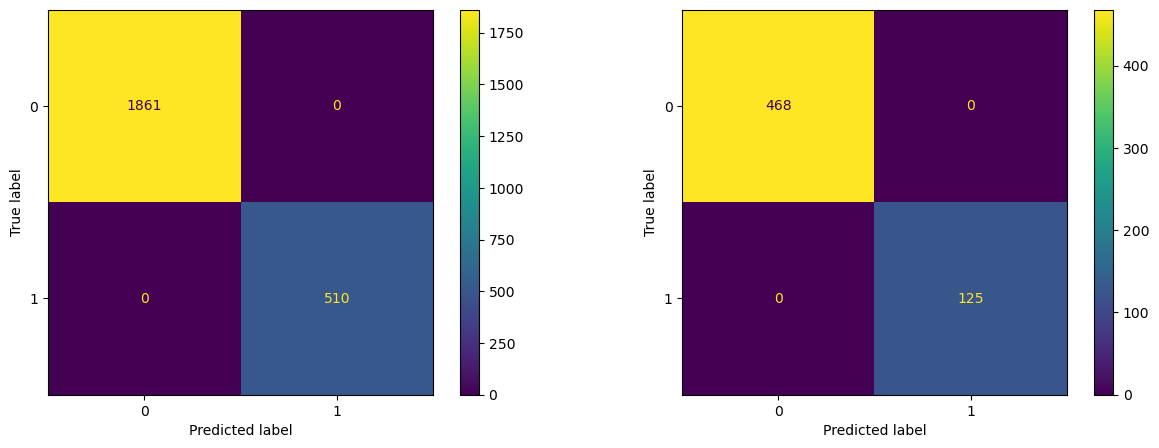

In [77]:
# Membuat confusiion matriks hasil prediksi dataset train
fig, ax =plt.subplots(1,2, figsize = (15,5))
confuscm_train = confusion_matrix(ytrain, y_pred_train_bestparam)
display_train = ConfusionMatrixDisplay(confusion_matrix=confuscm_train)
display_train.plot(ax=ax[0])

# Membuat confusiion matrik hasil prediksi dataset test
confuscm_testbestparam = confusion_matrix(ytest, y_pred_test_bestparam)
display_test = ConfusionMatrixDisplay(confusion_matrix=confuscm_testbestparam)
display_test.plot(ax=ax[1])



#### Tes perbandingan antara SVM dengan hyperprameter tuning dengan hyperparameter default 

Tahap ini bertujuan untuk membandingkan hasil prediksi berdasarkan nilai recall antara nilai recall yang dihasilkan model SVM yang menggunakan hyperparameter default (mode default) dengan nilai recall yang dihasilkan model SVM yang menggunakan hyperparameter hasil tuning. Sebagai perbandingan, SVM dengan mode default memiliki hyperparameter sebagai berikut (diambil dari dokumentasi scikitlearn) :

1. C            = 1

2. degree       = 3

3. gamma        = 1 / (n_features * X.var())

4. kernel       = RBF

Classification report y test SVM (default) : 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       468
           1       1.00      0.96      0.98       125

    accuracy                           0.99       593
   macro avg       0.99      0.98      0.99       593
weighted avg       0.99      0.99      0.99       593


Classification report y test SVM with hyperparameters from tuning: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       125

    accuracy                           1.00       593
   macro avg       1.00      1.00      1.00       593
weighted avg       1.00      1.00      1.00       593



,Baseline (Default Hyperparameter) - SVM,Tuning Hyperparameters - SVM
test - recall,0.96000,1.0
train - recall,0.97451,1.0


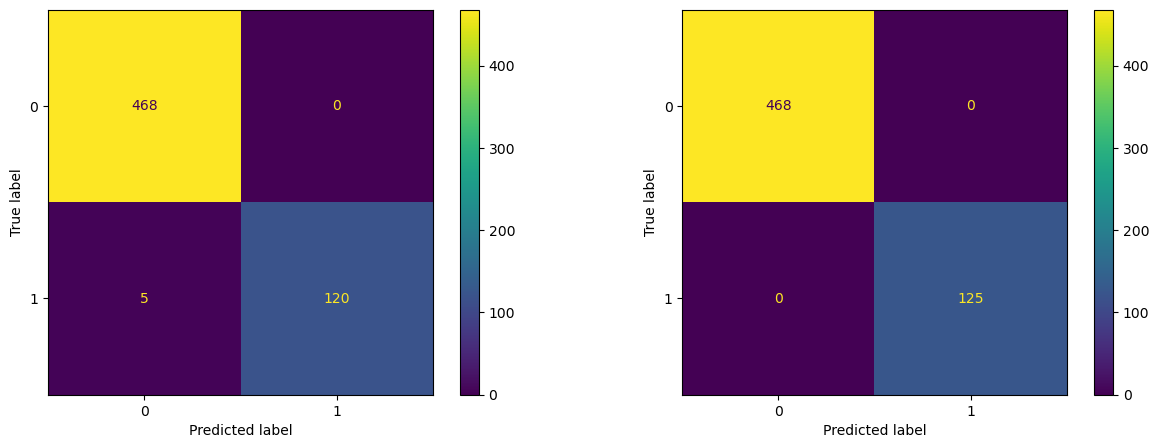

In [78]:
print('Classification report y test SVM (default) : ')
print(f'{classification_report(ytest, ytest_svm)}\n')

print('Classification report y test SVM with hyperparameters from tuning: ')
print(f'{classification_report(ytest, y_pred_test_bestparam)}')

# Membuat confusiion matriks hasil prediksi model SVM dengan hypperparameter default
fig, ax =plt.subplots(1,2, figsize = (15,5))
confuscm_default = confusion_matrix(ytest, ytest_svm)
display_train = ConfusionMatrixDisplay(confusion_matrix=confuscm_default)
display_train.plot(ax=ax[0])

# Membuat confusiion matriks hasil prediksi model SVM dengan hypperparameter hasil tuning
confuscm_testbestparam = confusion_matrix(ytest, y_pred_test_bestparam)
display_test = ConfusionMatrixDisplay(confusion_matrix=confuscm_testbestparam)
display_test.plot(ax=ax[1])

# Menampilkan dataframe nilai recall dari hasil klasifikasi model dengan hyperparameter default dan model dengan hyperparameter hasil
all_reports = performance_report(all_reports, ytrain, y_pred_train_bestparam, ytest, y_pred_test_bestparam, 'Tuning Hyperparameters - SVM')
all_reports

Dari hasil di atas dapat disimpulkan :

1. Pada SVM dengan hyperparameter default, nilai recall yang didapat sebesar 96 % (0.96), sementara pada model SVM dengan hyperparameter hasi tuning nilai recall yang didapat sebesar 100 %. Hal ini menunjukan bahwa ketika memakai parameter hasil tuning, akurasi dalam mengklasifikasi orang - orang yang gagal bayar berdasarkan populasi aktual dari kategori tersebut meningkat sebesar 4%. Ini artinya terdapat penurunan pada hasil false negative dan kenaikan pada nilai recall

2. Jumlah orang yang tergolong false negative (hyperparameter default) turun sebanyak 5 orang ketika menggunakan hyperparameter hasil tuning. Jika dilihat dari confussion matriks pada model yang menggunakan hyperparameter hasil tuning, penurunan tersebut diikuti dengan peningkatan true positive. Artinya model default lebih sulit dalam memprediksi orang - orang yang secara aktual memang mengalami kegagalan pembayaran dibandingkan model dengan hyperparameter hasil tuning


# 9. Model saving

In [79]:
#Model saving
with open('list_cols.txt', 'w') as file_1:
  json.dump(selected_columns, file_1)

with open('scaler.pkl', 'wb') as file_3:
  pickle.dump(scaler, file_3)

with open('model.pkl', 'wb') as file_4:
  pickle.dump(best_param, file_4)


# 10. Model inference

In [80]:
# Load model and other files

with open('list_cols.txt', 'r') as file_1:
  list_cols = json.load(file_1)

with open("scaler.pkl", "rb") as file_3:
  scaler = pickle.load(file_3)

with open("model.pkl", "rb") as file_4:
  model = pickle.load(file_4)

In [81]:
import pandas as pd

# Assuming data_dummy is your dictionary
data_dummy = {
    'limit_balance': [90000, 50000, 45000, 100000],
    'sex' : [2,1,1,2],
    'education_level' : [4,3,1,2],
    'martial_status' : [1,1,1,2],
    'age' : [29,34,25,50],
    'pay_sept': [0, 1, 1, 0],
    'pay_aug': [0, 1, 0, 1],
    'pay_jul': [1, 1, 0, 0],
    'pay_jun': [1, 1, 1, 0],
    'pay_may': [0, 0, 1, 1],
    'pay_apr': [1, 0, 1, 0],
    'bill_amt_sept': [4000, 18000, 25000, 10000],
    'bill_amt_aug': [11967, 5252, 6500, 41000],
    'bill_amt_jul': [390, 41000, 2300, 45000],
    'bill_amt_jun': [0, 1100, 0, 50000],
    'bill_amt_may': [390, 41000, 2300, 45000],
    'bill_amt_apr': [7000, 21000, 4600, 45000],
    'pay_amt_sept': [1, 1, 0, 1],
    'pay_amt_aug': [1, 1, 1, 1],
    'pay_amt_jul': [0, 0, 0, 1],
    'pay_amt_jun': [0, 1, 0, 1],
    'pay_amt_may': [1, 1, 1, 1],
    'pay_amt_apr': [0, 1, 1, 1],
}

# Create DataFrame
df_data_dummy = pd.DataFrame(data_dummy)

# Display DataFrame
df_data_dummy.head()

,limit_balance,sex,education_level,martial_status,age,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,bill_amt_sept,bill_amt_aug,bill_amt_jul,bill_amt_jun,bill_amt_may,bill_amt_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
0,90000,2,4,1,29,0,0,1,1,0,1,4000,11967,390,0,390,7000,1,1,0,0,1,0
1,50000,1,3,1,34,1,1,1,1,0,0,18000,5252,41000,1100,41000,21000,1,1,0,1,1,1
2,45000,1,1,1,25,1,0,0,1,1,1,25000,6500,2300,0,2300,4600,0,1,0,0,1,1
3,100000,2,2,2,50,0,1,0,0,1,0,10000,41000,45000,50000,45000,45000,1,1,1,1,1,1


In [82]:
# Membuat dataframe baru
data_inference = df_data_dummy[selected_columns]

# Proses scaling
data_inference_final = scaler.transform(data_inference)

# Membuat dataframe baru
data_inference_final = pd.DataFrame(data_inference_final,columns=selected_columns)

# Cek hasil
data_inference_final

,limit_balance,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr
0,-0.222222,0.0,0.0,1.0,1.0,0.0,1.0,-0.545725,-0.545252,-0.504414,-0.448636,-0.454508,-0.439294
1,-0.444444,1.0,1.0,1.0,1.0,0.0,0.0,-0.545725,-0.545252,-0.504414,-0.448365,-0.454508,-0.439031
2,-0.472222,1.0,0.0,0.0,1.0,1.0,1.0,-0.545973,-0.545252,-0.504414,-0.448636,-0.454508,-0.439031
3,-0.166667,0.0,1.0,0.0,0.0,1.0,0.0,-0.545725,-0.545252,-0.504161,-0.448365,-0.454508,-0.439031


In [83]:
# Proses prediksi
predicted_default = model.predict(data_inference_final)

# Buat dataframe baru
predicted_default = pd.DataFrame(predicted_default, columns=['Predicted default user next month'])

# Cek hasil
predicted_default

,Predicted default user next month
0,0
1,1
2,1
3,0


In [84]:
# Membuat data frame final
df_inference_final = pd.concat([data_inference_final, predicted_default], axis = 1)

# Cek hasil
df_inference_final

,limit_balance,pay_sept,pay_aug,pay_jul,pay_jun,pay_may,pay_apr,pay_amt_sept,pay_amt_aug,pay_amt_jul,pay_amt_jun,pay_amt_may,pay_amt_apr,Predicted default user next month
0,-0.222222,0.0,0.0,1.0,1.0,0.0,1.0,-0.545725,-0.545252,-0.504414,-0.448636,-0.454508,-0.439294,0
1,-0.444444,1.0,1.0,1.0,1.0,0.0,0.0,-0.545725,-0.545252,-0.504414,-0.448365,-0.454508,-0.439031,1
2,-0.472222,1.0,0.0,0.0,1.0,1.0,1.0,-0.545973,-0.545252,-0.504414,-0.448636,-0.454508,-0.439031,1
3,-0.166667,0.0,1.0,0.0,0.0,1.0,0.0,-0.545725,-0.545252,-0.504161,-0.448365,-0.454508,-0.439031,0


# 12. Kesimpulan

### 12.1. EDA

1. Presentase orang yang masuk dalam kategori gagal bayar sebesar 21.42 %, sementara jumlah orang yang tidak masuk dalam kategori tersebut sebanyak 78.58 %. Dataset tersebut dapat dianggap sebagai data imbalance karena salah satu nilai proporsinya jauh lebih banyak dibandingkan proporsi nilai yang lainnya

2. Berdasarkan tingkat akhir pendidikan, jumlah terbesar pemegang kartu kredit berasal dari kalangan dengan tingkat pendidikan graduate degree, diikuti dengan bachelor degree, lalu high school, dan terakhir others (tidak diketahui apa maksud others). Selain itu, status gagal bayar dan tidak gagal bayar tidak dipengaruhi oleh tingkat akhir pendidikan melainkan lebih kepada kelompok dengan jumlah pemegang kartu kredit terbesar

3. Pemegang kartu kredit akan lebih sedikit pada kelompok usia di atas 31 tahun dan distribusi nya akan terus berkurang hingga memasuki usia senja. Hal ini mengindikasikan adanya hubungan waktu produktif dengan pemakaian kartu kredit

4. Limit balance tidak dipengaruhi oleh umur seseorang, indikasinya limit balance kemungkinan besar dipengaruhi oleh faktor lain seperti jumlah tabungan dan history pembayaran tagihan

5. Status gagal bayar juga tidak dipengaruhi oleh umur seseorang, hal ini mengindikasikan bahwa status gagal bayar tidak memiliki hubungan dengan usia produktif

### 12.2. Model analysis

1. Model dievaluasi dengan matriks recall karena tujuan dalam pembuatan model ini adalah untuk memprediksi orang yang kemungkinan akan mengalami gagal bayar sehingga kita dapat meminimalkan false negative. False negative menggambarkan customer yang dianggap (berdasarkan hasil prediksi) dapat membayar tagihan kredit di bulan depan namun pada kenyataanya customer tersebut gagal membayar tagihannya

2. Terdapat 3 model yang ditrial dalam mode default, yatu losgistic regression, KNN, dan SVM. Dari ketiga model tersebut, model logistic regression memiliki nilai recall tertinggi pada tiap dataset yang diprediksi (train dan test) dimana nilai recallnya sebesar 1 atau 100 % untuk masing - masing prediksi

3. Dari ketiga model yang ditrial pada mode default, dipilih model SVM dengan alasan :
    - Dataset yang dipakai masih banyak outliers. Dari 13 kolom yang terpilih sebagai feature, hanya 1 kolom yang memiliki presentase outliers dibawah 8 %
    - Untuk mengantisipasi jika model ini digunakan pada dataset yang memiliki lebih banyak outliers
    - Nilai recall yang dihasilkan pada mode default tidak terlalu jauh perbedaanya dengan recall yang dihasilkan logistic linear (0.97 pada dataset train dan 0.96 pada dataset test)
    - Overfitting tidak significant karena perbedaan antara nilai recall yang dihasilkan dari dataset train dengan nilai recall yang dihasilkan dari dataset test hanya 0.01. Sebagai informasi, nilai recall yang dihasilkan dari dataset train sebesar 0.97 dan nilai recal yang dihasilkan dari dataset test sebesar 0.96

4. Nilai hyperparameter yang didapatkan setelah proses hyperparameter tuning adalah sebagai berikut :

    - c             = 0.1

    - degree        = 1

    - gamma         = 1

    - kernel        = polynomial
    
5. Nilai recall yang dihasilkan oleh model SVM Polynomial dengan hyperparameter hasil tuning memiliki nilai sebesar 1 atau 100 %, sementara nilai recall yang dihasilkan oleh model SVM dengan hyperparameter default memiliki nilai sebesar 0.96 atau 96 %. Ini artinya model SVM Polynomial yang menggunakan hyperparameter tunning dapat meningkatkan nilai recall sebesar 4 % dibandingkan nilai recall sebelumnya yang menggunakan model SVM default (kernel RBF), atau dapat dikatakn model SVM polynomial dengan hyperparameter tuning memiliki nilai error 4 % lebih rendah saat memprediksi kategori customer yang akan mengalami gagal bayar